In [73]:
import os
import json
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# 한글 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

In [74]:
# 경로 수정해서 사용하세요
FILE_PATH = './data/data.csv'

def read_csv_safely(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="cp949")

df = pd.read_csv(FILE_PATH)

print("✅ shape:", df.shape)
print("✅ columns:", df.columns.tolist())
df.head(10)

✅ shape: (34617, 20)
✅ columns: ['Product_Number', 'T일 예정 수주량', 'T+1일 예정 수주량', 'T+2일 예정 수주량', 'T+3일 예정 수주량', 'T+4일 예정 수주량', '작년 T일 예정 수주량', '작년 T+1일 예정 수주량', '작년 T+2일 예정 수주량', '작년 T+3일 예정 수주량', '작년 T+4일 예정 수주량', 'T일 예상 수주량', 'T+1일 예상 수주량', 'T+2일 예상 수주량', 'T+3일 예상 수주량', 'T+4일 예상 수주량', 'DateTime', 'DoW', 'Temperature', 'Humidity']


,Product_Number,T일 예정 수주량,T+1일 예정 수주량,T+2일 예정 수주량,T+3일 예정 수주량,T+4일 예정 수주량,작년 T일 예정 수주량,작년 T+1일 예정 수주량,작년 T+2일 예정 수주량,작년 T+3일 예정 수주량,작년 T+4일 예정 수주량,T일 예상 수주량,T+1일 예상 수주량,T+2일 예상 수주량,T+3일 예상 수주량,T+4일 예상 수주량,DateTime,DoW,Temperature,Humidity
0,Product_ac,0,0,0,2,3,7,3,0,2,0,0,8,6,0,0,2022-03-13 7:04,Sunday,20.767619,50.015714
1,Product_c2,166,130,130,130,0,0,126,126,126,126,126,126,0,126,126,2022-02-25 11:34,Friday,13.666164,12.710959
2,Product_d7,21,11,10,18,20,24,0,11,0,0,0,0,0,0,0,2022-02-10 6:31,Thursday,14.106374,28.374854
3,Product_9a,28,61,50,74,60,0,0,0,44,36,30,13,0,0,25,2022-02-17 6:26,Thursday,10.440606,12.133030
4,Product_b9,127,0,0,11,10,16,21,92,101,0,103,99,159,69,0,2022-03-13 15:38,Sunday,20.767619,50.015714
5,Product_cf,0,0,202,216,223,239,236,258,0,338,337,218,245,96,0,2022-02-17 5:54,Thursday,10.440606,12.133030
6,Product_b9,10,0,39,54,128,102,0,120,111,110,118,59,0,0,0,2022-02-09 11:55,Wednesday,8.872222,23.941111
7,Product_e6,38,20,0,0,17,11,29,0,0,0,0,19,25,24,87,2022-03-06 9:57,Sunday,14.541818,13.350000
8,Product_c9,208,0,0,57,21,29,42,149,193,0,185,219,367,437,285,2022-03-13 7:06,Sunday,20.767619,50.015714
9,Product_ad,0,0,46,16,35,52,42,50,0,53,32,43,135,196,0,2022-02-16 7:03,Wednesday,12.673571,13.080714


In [75]:
def basic_overview(df):
    info = {
        "rows": df.shape[0],
        "cols": df.shape[1],
        "memory_mb": round(df.memory_usage(deep=True).sum() / (1024**2), 3),
        "dtypes": df.dtypes.astype(str).to_dict(),
        "nunique": df.nunique().to_dict(),
    }
    return info

overview = basic_overview(df)
print(json.dumps(overview, indent=2, ensure_ascii=False))

{
  "rows": 34617,
  "cols": 20,
  "memory_mb": 11.262,
  "dtypes": {
    "Product_Number": "object",
    "T일 예정 수주량": "int64",
    "T+1일 예정 수주량": "int64",
    "T+2일 예정 수주량": "int64",
    "T+3일 예정 수주량": "int64",
    "T+4일 예정 수주량": "int64",
    "작년 T일 예정 수주량": "int64",
    "작년 T+1일 예정 수주량": "int64",
    "작년 T+2일 예정 수주량": "int64",
    "작년 T+3일 예정 수주량": "int64",
    "작년 T+4일 예정 수주량": "int64",
    "T일 예상 수주량": "int64",
    "T+1일 예상 수주량": "int64",
    "T+2일 예상 수주량": "int64",
    "T+3일 예상 수주량": "int64",
    "T+4일 예상 수주량": "int64",
    "DateTime": "object",
    "DoW": "object",
    "Temperature": "float64",
    "Humidity": "float64"
  },
  "nunique": {
    "Product_Number": 117,
    "T일 예정 수주량": 481,
    "T+1일 예정 수주량": 366,
    "T+2일 예정 수주량": 360,
    "T+3일 예정 수주량": 372,
    "T+4일 예정 수주량": 373,
    "작년 T일 예정 수주량": 381,
    "작년 T+1일 예정 수주량": 365,
    "작년 T+2일 예정 수주량": 411,
    "작년 T+3일 예정 수주량": 385,
    "작년 T+4일 예정 수주량": 377,
    "T일 예상 수주량": 378,
    "T+1일 예상 수주량": 369,
    "T+2일 예상 수주량": 383

In [83]:
# 수치형 컬럼만 선택
num_cols = df.select_dtypes(include=[np.number]).columns

# 0 비율 계산
zero_ratio = (df[num_cols] == 0).sum() / len(df)
non_zero_ratio = 1 - zero_ratio

# 결과 정리
ratio_df = pd.DataFrame({
    "Zero_Ratio": zero_ratio.round(4),
    "NonZero_Ratio": non_zero_ratio.round(4)
}).sort_values("Zero_Ratio", ascending=False)

print(ratio_df)

                Zero_Ratio  NonZero_Ratio
T+2일 예정 수주량         0.5825         0.4175
작년 T+4일 예정 수주량      0.5631         0.4369
T+3일 예정 수주량         0.5588         0.4412
T+4일 예정 수주량         0.4916         0.5084
작년 T일 예정 수주량        0.4785         0.5215
T일 예상 수주량           0.4480         0.5520
T+2일 예상 수주량         0.4398         0.5602
T+4일 예상 수주량         0.4372         0.5628
T+1일 예상 수주량         0.4294         0.5706
T+1일 예정 수주량         0.4231         0.5769
작년 T+1일 예정 수주량      0.4171         0.5829
T+3일 예상 수주량         0.3979         0.6021
작년 T+3일 예정 수주량      0.3827         0.6173
작년 T+2일 예정 수주량      0.2694         0.7306
T일 예정 수주량           0.1933         0.8067
Temperature         0.0000         1.0000
Humidity            0.0000         1.0000


In [76]:
# 결측치 요약
na_summary = df.isna().sum().sort_values(ascending=False).to_frame("na_count")
na_summary["na_rate"] = na_summary["na_count"] / len(df)
display(na_summary)

,na_count,na_rate
Product_Number,0,0.0
T일 예정 수주량,0,0.0
Temperature,0,0.0
DoW,0,0.0
DateTime,0,0.0
T+4일 예상 수주량,0,0.0
T+3일 예상 수주량,0,0.0
T+2일 예상 수주량,0,0.0
T+1일 예상 수주량,0,0.0
T일 예상 수주량,0,0.0


In [77]:
# 0 비율: 이름에 '수주량' 또는 '예상' 들어가는 열 대상
target_like_cols = [c for c in df.columns if ("수주량" in c or "예상" in c)]
zero_rate = {}
for c in target_like_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        zero_rate[c] = float((df[c] == 0).mean())
zero_rate = pd.Series(zero_rate, name="zero_rate").sort_values(ascending=False)
display(zero_rate)

T+2일 예정 수주량       0.582459
작년 T+4일 예정 수주량    0.563105
T+3일 예정 수주량       0.558772
T+4일 예정 수주량       0.491637
작년 T일 예정 수주량      0.478493
T일 예상 수주량         0.448046
T+2일 예상 수주량       0.439755
T+4일 예상 수주량       0.437242
T+1일 예상 수주량       0.429413
T+1일 예정 수주량       0.423116
작년 T+1일 예정 수주량    0.417107
T+3일 예상 수주량       0.397926
작년 T+3일 예정 수주량    0.382702
작년 T+2일 예정 수주량    0.269405
T일 예정 수주량         0.193344
Name: zero_rate, dtype: float64

In [78]:
# 수치형 기술통계
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
T일 예정 수주량,34617.0,101.468267,168.004255,0.000000,2.000000,30.000000,124.000000,1131.000000
T+1일 예정 수주량,34617.0,67.014039,131.212735,0.000000,0.000000,5.000000,69.000000,883.000000
T+2일 예정 수주량,34617.0,48.758298,115.200052,0.000000,0.000000,0.000000,36.000000,885.000000
T+3일 예정 수주량,34617.0,51.888552,115.111868,0.000000,0.000000,0.000000,44.000000,872.000000
T+4일 예정 수주량,34617.0,60.855822,123.274794,0.000000,0.000000,1.000000,62.000000,865.000000
작년 T일 예정 수주량,34617.0,63.709969,127.469879,0.000000,0.000000,1.000000,67.000000,863.000000
작년 T+1일 예정 수주량,34617.0,70.922726,133.088260,0.000000,0.000000,8.000000,79.000000,909.000000
작년 T+2일 예정 수주량,34617.0,89.926568,146.436175,0.000000,0.000000,28.000000,109.000000,912.000000
작년 T+3일 예정 수주량,34617.0,76.280642,138.961635,0.000000,0.000000,11.000000,88.000000,909.000000
작년 T+4일 예정 수주량,34617.0,55.156339,120.926792,0.000000,0.000000,0.000000,49.000000,886.000000


In [79]:
# ============================================
# 🕐 DateTime 컬럼 직접 변환 (결측 없이, 열 증가 없이)
# ============================================

if "DateTime" in df.columns:
    # 1️⃣ 원본 문자열을 임시 변수에 보관 (df에 추가 X)
    _raw = df["DateTime"].astype(str).str.strip()

    # 2️⃣ 포맷 지정 파싱 (초 포함)
    parsed = pd.to_datetime(_raw, format="%Y-%m-%d %H:%M:%S", errors="coerce")

    # 3️⃣ 실패분만 일반 파서로 재시도 (포맷 다양성 보완)
    mask = parsed.isna() & _raw.notna()
    if mask.any():
        parsed.loc[mask] = pd.to_datetime(_raw.loc[mask], errors="coerce")

    # 4️⃣ 최종적으로 원본 컬럼 덮어쓰기
    df["DateTime"] = parsed

    # ✅ 변환 결과 요약
    print("✅ DateTime 변환 완료")
    print("결측치 개수:", df["DateTime"].isna().sum())
    print("데이터 타입:", df["DateTime"].dtype)
else:
    print("❌ 'DateTime' 컬럼이 존재하지 않습니다.")

✅ DateTime 변환 완료
결측치 개수: 0
데이터 타입: datetime64[ns]


In [81]:
# 제품 키
prod_col = "Product_Number" if "Product_Number" in df.columns else None

# 완전 중복 행
dup_all = df.duplicated().sum()
print("🔁 완전 중복 행 수:", dup_all)

# (제품, 날짜) 중복
if prod_col and 'DateTime':
    dup_key = df.duplicated(subset=[prod_col, 'DateTime']).sum()
    print(f"🔁 ({prod_col}, {'DateTime'}) 기준 중복 수:", dup_key)

🔁 완전 중복 행 수: 2
🔁 (Product_Number, DateTime) 기준 중복 수: 723


In [20]:
# 이상치 탐지 (Humidity, Temperature 중심 IQR)
def iqr_outlier_bounds(series, q1=0.25, q3=0.75, factor=1.5):
    Q1 = series.quantile(q1)
    Q3 = series.quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - factor * IQR
    high = Q3 + factor * IQR
    return low, high

for col in ["Humidity", "Temperature"]:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        low, high = iqr_outlier_bounds(df[col].dropna())
        n_low = int((df[col] < low).sum())
        n_high = int((df[col] > high).sum())
        print(f"[{col}] IQR 하한={low:.3f}, 상한={high:.3f}, 저하한 개수={n_low}, 고상한 개수={n_high}, 최댓값={df[col].max():.3f}")

[Humidity] IQR 하한=-1.091, 상한=59.951, 저하한 개수=0, 고상한 개수=228, 최댓값=1021.615
[Temperature] IQR 하한=-0.250, 상한=36.177, 저하한 개수=0, 고상한 개수=0, 최댓값=27.596


- Humidity는 실제 물리적 한계(0~100%)가 있는데,
여기서 1021.6이라는 값은 단위 오류 혹은 센서 측정 오류로 보입니다.
→ 즉, 명백한 이상치(outlier).
- Temperature는 8~27℃ 정도로 매우 정상적인 범위에 있으므로 정상 분포입니다.

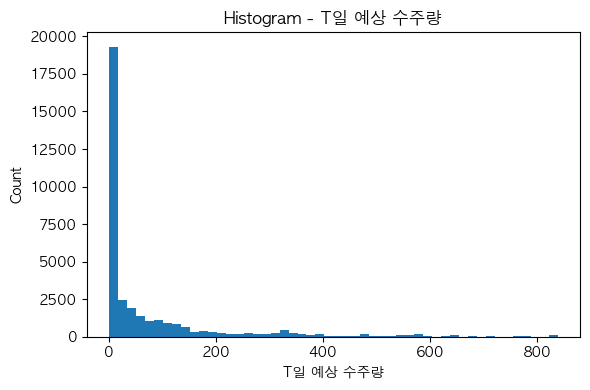

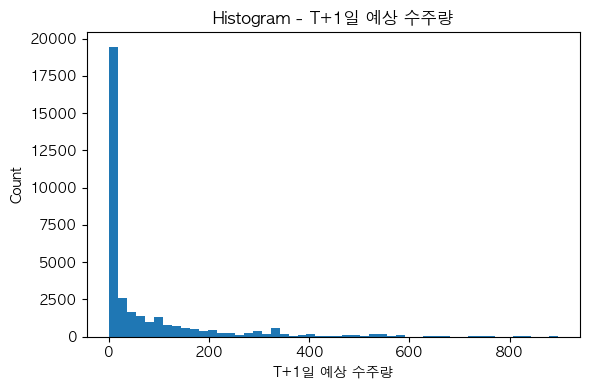

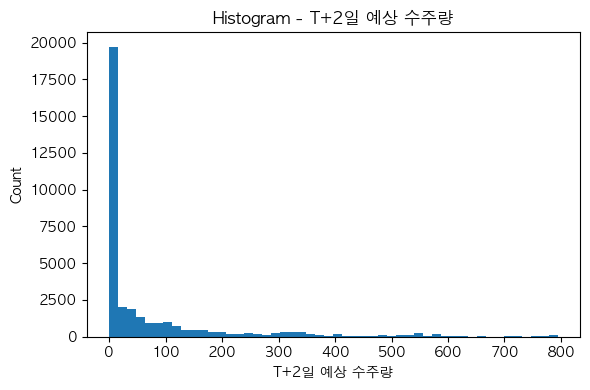

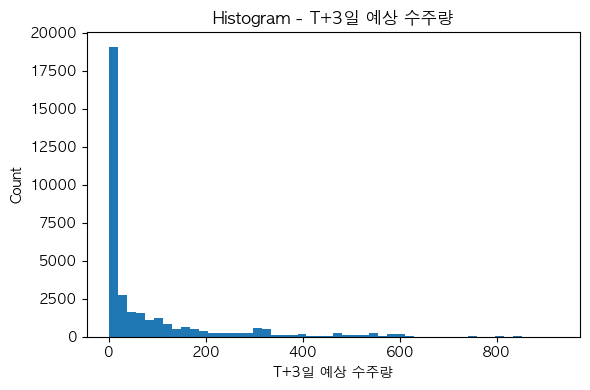

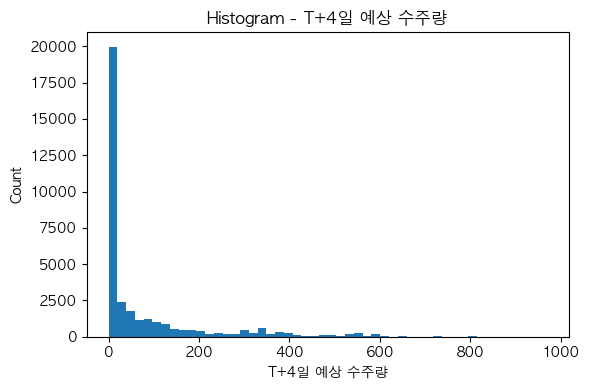

In [21]:
# 분포 확인: 히스토그램(예: T일~T+4일 예상 수주량)
hist_cols = [c for c in df.columns if "예상 수주량" in c]

for c in hist_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        plt.figure(figsize=(6,4))
        plt.hist(df[c].dropna(), bins=50)
        plt.title(f"Histogram - {c}")
        plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

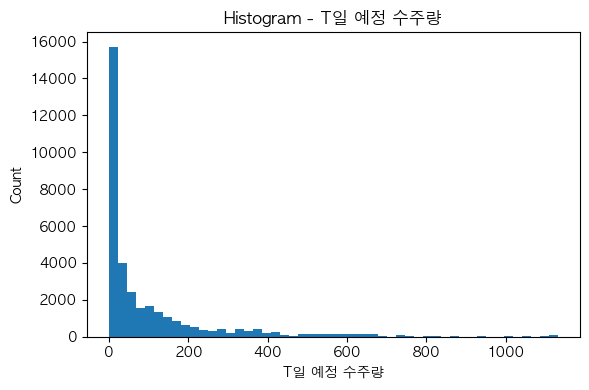

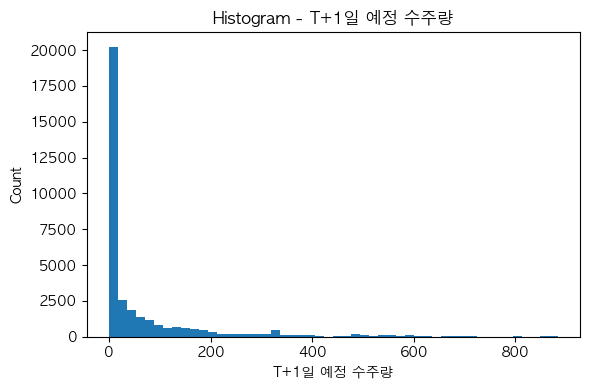

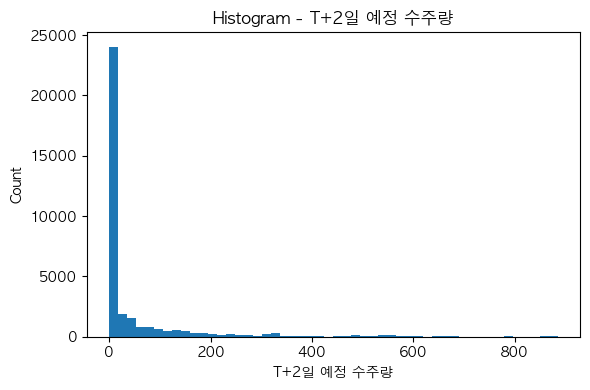

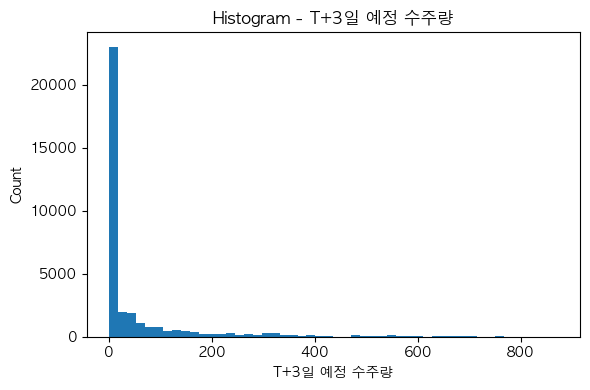

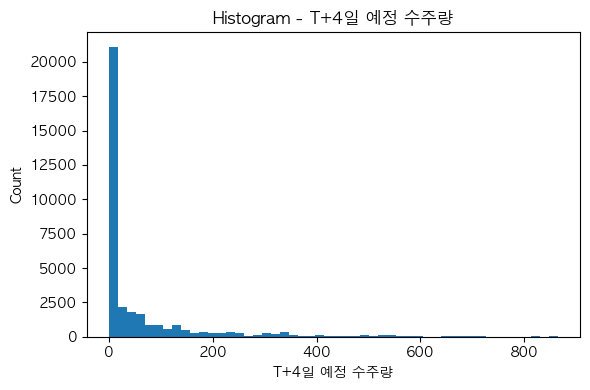

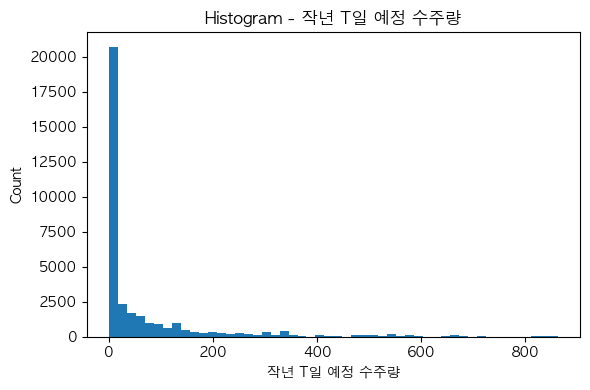

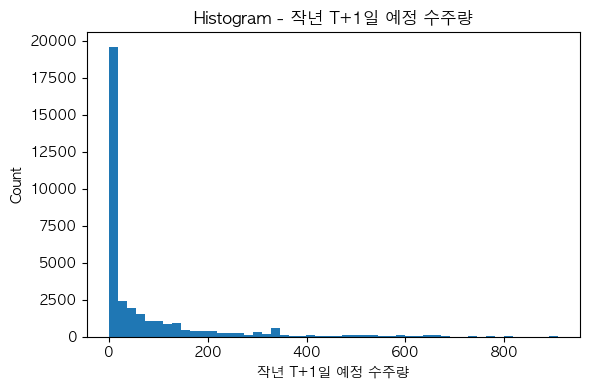

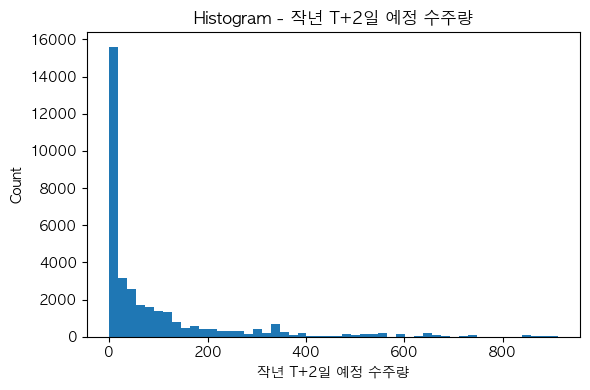

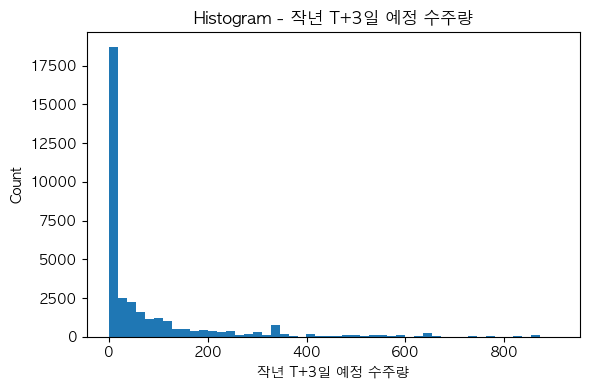

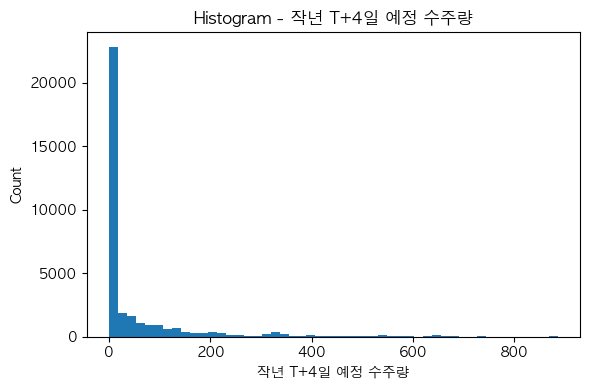

In [22]:
# 분포 확인: 히스토그램(예: T일~T+4일 예정 수주량)
hist_cols = [c for c in df.columns if "예정 수주량" in c]

for c in hist_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        plt.figure(figsize=(6,4))
        plt.hist(df[c].dropna(), bins=50)
        plt.title(f"Histogram - {c}")
        plt.xlabel(c); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

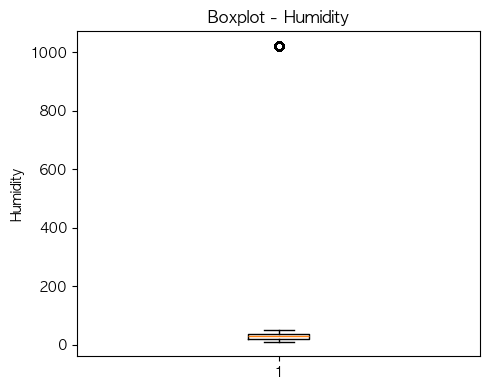

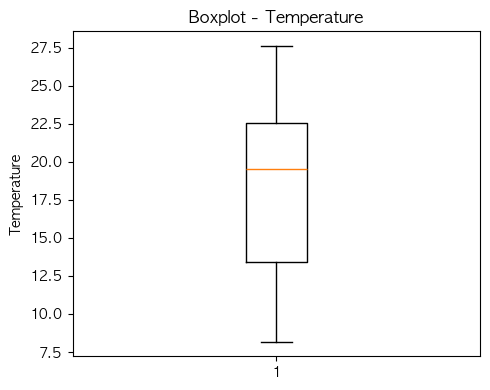

In [23]:
# 박스 플롯 (Temperature, Humidity)
for c in ["Humidity", "Temperature"]:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        plt.figure(figsize=(5,4))
        plt.boxplot(df[c].dropna(), vert=True)
        plt.title(f"Boxplot - {c}")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()

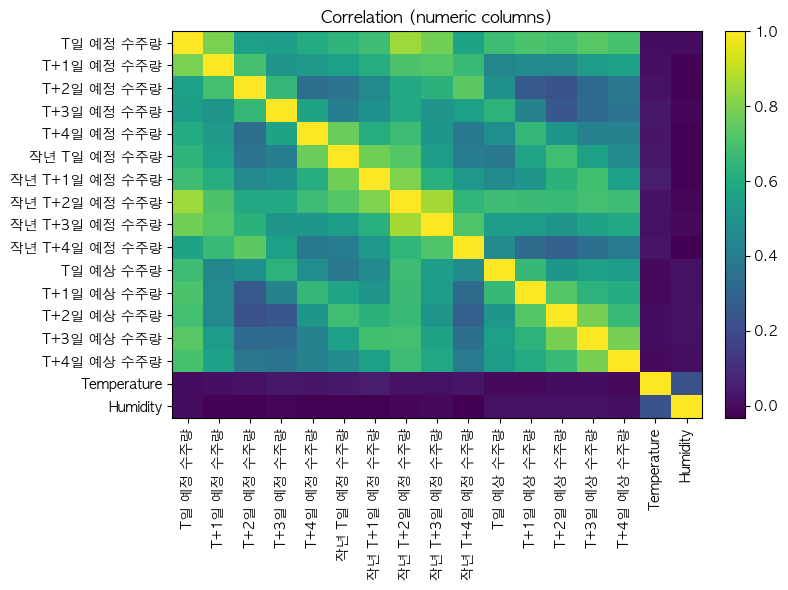

In [24]:
# 상관관계 (수치형만) – heatmap (matplotlib)
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation (numeric columns)")
    plt.tight_layout()
    plt.show()

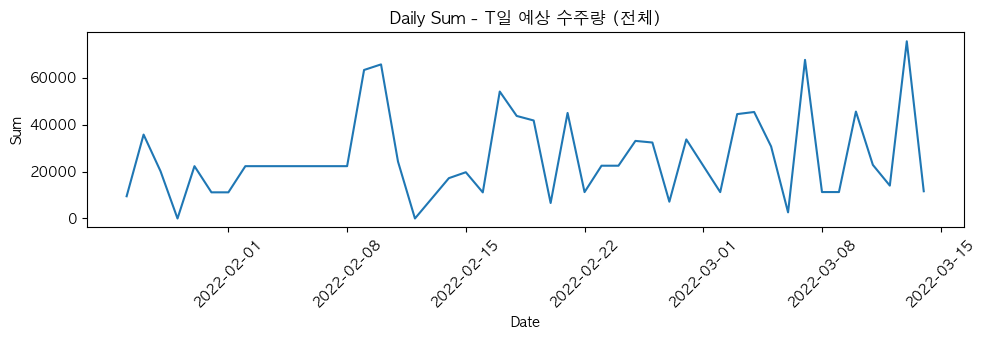

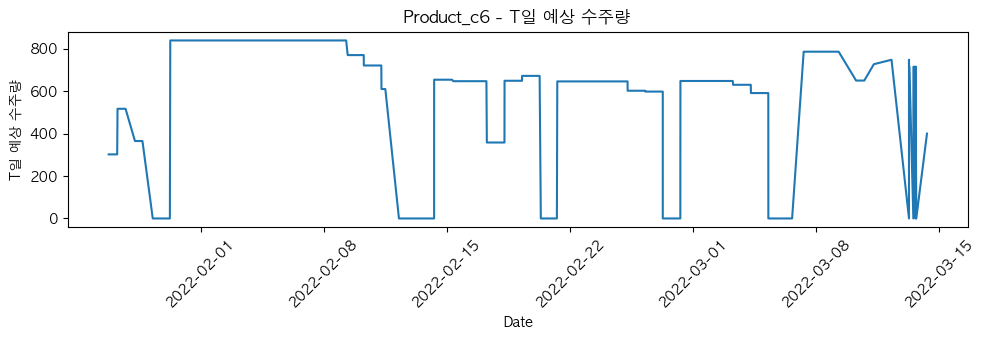

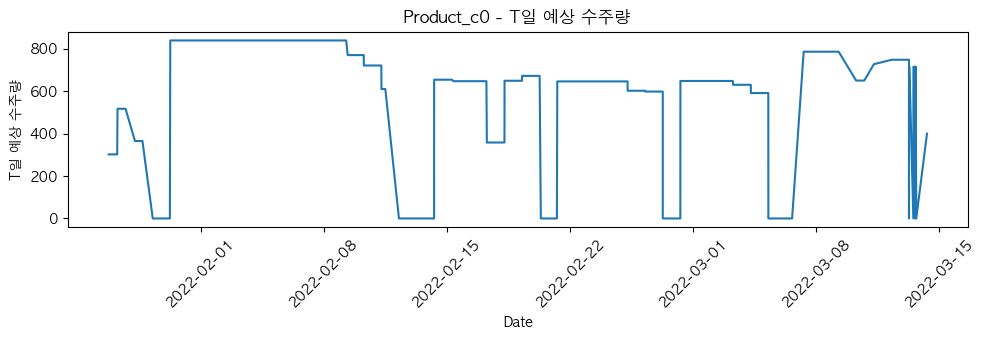

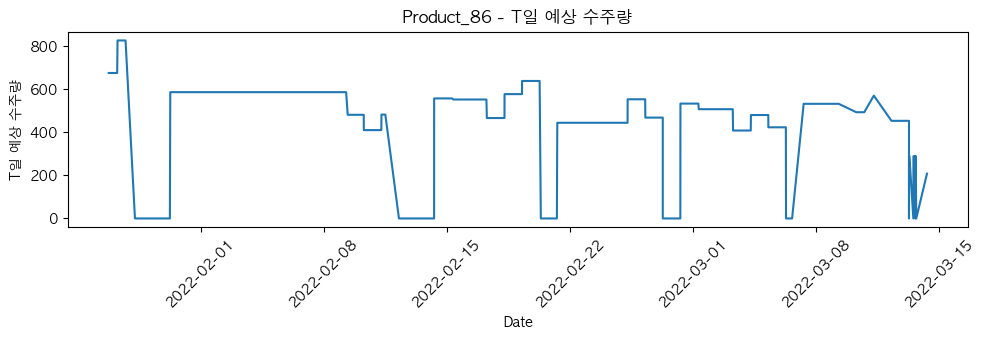

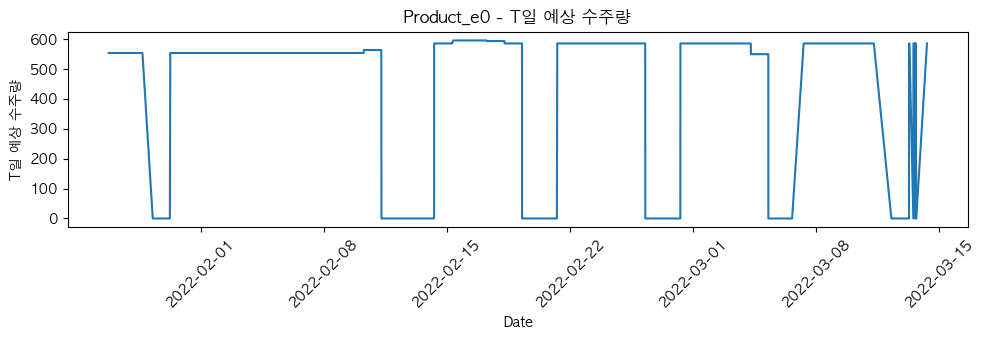

In [25]:
# 시계열 점검 (전체/제품별)
if date_col:
    # 전체 합산(예: T일 예상 수주량)
    agg_target = None
    for c in ["T일 예상 수주량", "T+1일 예상 수주량"]:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            agg_target = c
            break

    if agg_target:
        daily_sum = df.groupby(df[date_col].dt.date)[agg_target].sum().sort_index()
        plt.figure(figsize=(10,3.5))
        plt.plot(daily_sum.index, daily_sum.values)
        plt.title(f"Daily Sum - {agg_target} (전체)")
        plt.xlabel("Date"); plt.ylabel("Sum")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 제품별 샘플 시계열
    if prod_col and agg_target:
        # 상위 물량 기준 상위 4개 제품 추출
        top_prod = (df.groupby(prod_col)[agg_target]
                      .sum().sort_values(ascending=False).head(4).index.tolist())
        for p in top_prod:
            sub = df[df[prod_col] == p].copy()
            sub = sub.sort_values(by=date_col)
            plt.figure(figsize=(10,3.5))
            plt.plot(sub[date_col], sub[agg_target])
            plt.title(f"{p} - {agg_target}")
            plt.xlabel("Date"); plt.ylabel(agg_target)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [26]:
## 품목/요일 분포 요약

# 품목별 샘플 수
if prod_col:
    prod_counts = df[prod_col].value_counts().head(20)
    print("📦 상위 20개 품목별 샘플 수:")
    display(prod_counts)

# 요일 분포
if "DoW" in df.columns:
    dow_counts = df["DoW"].value_counts().sort_index()
    print("📅 요일 분포:")
    display(dow_counts)

📦 상위 20개 품목별 샘플 수:


Product_Number
Product_99    610
Product_9e    610
Product_ac    305
Product_ed    305
Product_b2    305
Product_a1    305
Product_ef    305
Product_e8    305
Product_d9    305
Product_a2    305
Product_bc    305
Product_b4    305
Product_c8    305
Product_b0    305
Product_d2    305
Product_eb    305
Product_89    305
Product_b5    305
Product_c5    305
Product_94    305
Name: count, dtype: int64

📅 요일 분포:


DoW
Friday       5430
Monday       5111
Saturday     5796
Sunday       6822
Thursday     4648
Tuesday      4088
Wednesday    2722
Name: count, dtype: int64

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 13
[LightGBM] [Info] Start training from score 71.428845
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2723
[LightGBM] [Info] Number of data points in the train set: 27693, number of used features: 13
[LightGBM] [Info] Start training from score 71.428845
=== 성능 비교 (Test) ===
[Base]   MAE=9.4858, RMSE=15.8153, R2=0.9857
[+Int]   MAE=9.4858, RMSE=15.8153, R2=0.9857

=== Feature Importance 변화 (상위 15개) ===
   

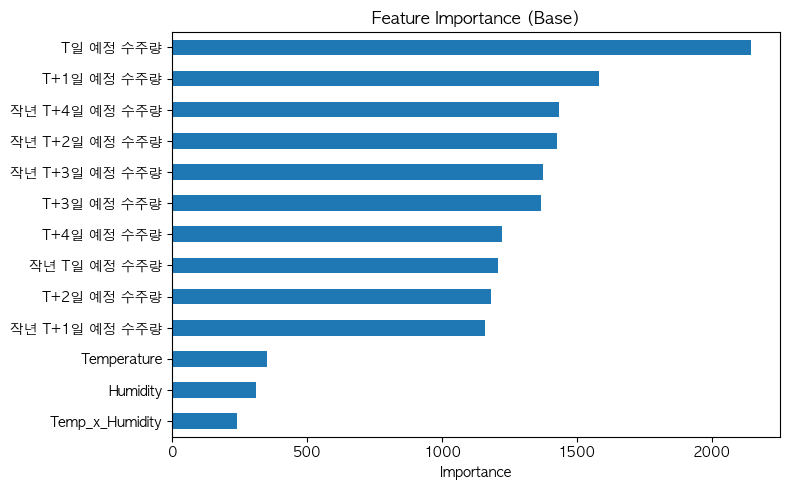

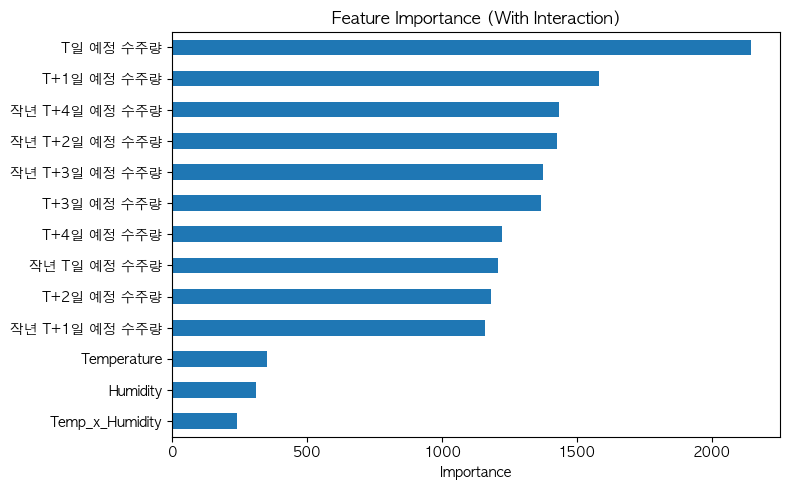

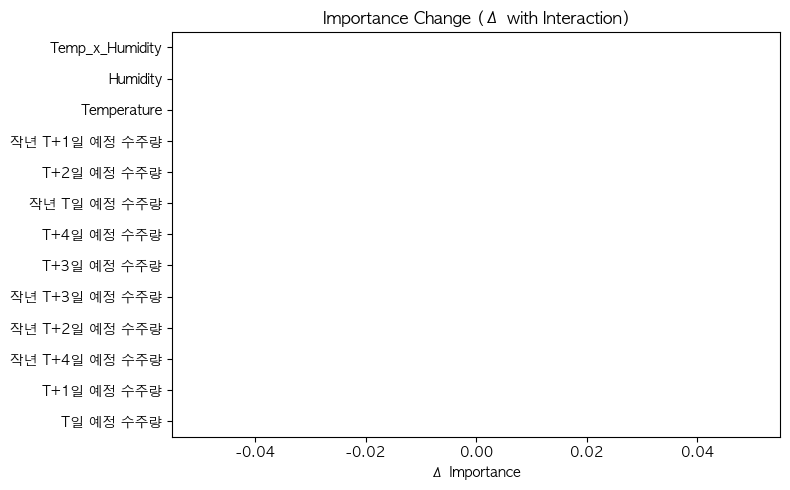

In [31]:
# =====================================
# 🧼 2) 기본 정리
# =====================================
# 날짜형 변환
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# Humidity 이상치 절단 (0~100)
if "Humidity" in df.columns:
    df["Humidity"] = df["Humidity"].clip(lower=0, upper=100)

# =====================================
# 🎯 3) 타깃 변수 정의
# =====================================
if "T일 예상 수주량" not in df.columns:
    raise ValueError("타깃 컬럼 'T일 예상 수주량'을 찾을 수 없습니다.")
target_col = "T일 예상 수주량"
y = df[target_col]

# =====================================
# 🧩 4) 기본 Feature 선정 (타깃/유사 타깃 제외)
# =====================================
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
feature_cols = [c for c in num_cols if "예상 수주량" not in c]  # 모든 '...예상 수주량' 제외
if target_col in feature_cols:
    feature_cols.remove(target_col)

# =====================================
# ⚙️ 5) Interaction 변수 생성 (덮어쓰기 보장)
# =====================================
if all(col in df.columns for col in ["Temperature", "Humidity"]):
    df["Temp_x_Humidity"] = df["Temperature"] * df["Humidity"]
else:
    # 둘 중 하나라도 없으면 0으로 생성 (코드 일관성)
    df["Temp_x_Humidity"] = 0.0

# 피처 목록에 interaction 추가 + 중복 제거(순서 보존)
feature_cols_int = list(dict.fromkeys(feature_cols + ["Temp_x_Humidity"]))

# =====================================
# 🧪 6) Train/Test 분할 (중복 컬럼/NaN/inf 방지 포함)
# =====================================
X_base = df[feature_cols].copy()
X_int  = df[feature_cols_int].copy()

# DataFrame 단계에서도 중복 컬럼 제거
X_base = X_base.loc[:, ~X_base.columns.duplicated()]
X_int  = X_int.loc[:,  ~X_int.columns.duplicated()]

# 안전장치: inf/NaN 처리
X_base = X_base.replace([np.inf, -np.inf], np.nan).fillna(0)
X_int  = X_int.replace([np.inf, -np.inf], np.nan).fillna(0)

# (선택) 중복 컬럼 존재 여부 최종 확인
# print([c for c in X_int.columns if X_int.columns.tolist().count(c) > 1])

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y, test_size=0.2, random_state=42)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_int,  y, test_size=0.2, random_state=42)

# =====================================
# 🧠 7) LightGBM 학습
# =====================================
params = dict(
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_base = lgb.LGBMRegressor(**params).fit(Xb_train, yb_train)
model_int  = lgb.LGBMRegressor(**params).fit(Xi_train, yi_train)

# =====================================
# 📊 8) 성능 비교
# =====================================
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, pred)),  # ← 수정됨
        "R2": r2_score(y_test, pred)
    }

res_base = evaluate(model_base, Xb_test, yb_test)
res_int  = evaluate(model_int,  Xi_test, yi_test)

print("=== 성능 비교 (Test) ===")
print(f"[Base]   MAE={res_base['MAE']:.4f}, RMSE={res_base['RMSE']:.4f}, R2={res_base['R2']:.4f}")
print(f"[+Int]   MAE={res_int['MAE']:.4f}, RMSE={res_int['RMSE']:.4f}, R2={res_int['R2']:.4f}")

# =====================================
# 🔍 9) Feature Importance 비교
# =====================================
fi_base = pd.Series(model_base.feature_importances_, index=X_base.columns)
fi_int  = pd.Series(model_int.feature_importances_,  index=X_int.columns)

fi_compare = pd.concat([fi_base.rename("Base"), fi_int.rename("With_Interaction")], axis=1)
fi_compare["Delta"] = fi_compare["With_Interaction"] - fi_compare["Base"]
fi_compare = fi_compare.sort_values("With_Interaction", ascending=False)

print("\n=== Feature Importance 변화 (상위 15개) ===")
print(fi_compare.head(15))

# =====================================
# 📈 10) 시각화 (각각 단일 플롯)
# =====================================
plt.figure(figsize=(8,5))
fi_base.sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title("Feature Importance (Base)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
fi_int.sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title("Feature Importance (With Interaction)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
fi_compare["Delta"].sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title("Importance Change (Δ with Interaction)")
plt.xlabel("Δ Importance")
plt.tight_layout()
plt.show()

✅ 제품 수: 117개


,T일 예상 수주량,T+1일 예상 수주량,T+2일 예상 수주량,T+3일 예상 수주량,T+4일 예상 수주량
Product_Number,,,,,
Product_84,5.651246,8.640569,4.839858,4.540925,11.843416
Product_85,1.708185,3.199288,2.601423,1.231317,11.345196
Product_86,395.960656,339.944262,355.534426,381.232787,381.481967
Product_87,27.636364,25.902357,31.791246,35.191919,42.558923
Product_88,196.544262,228.904918,227.737705,216.878689,226.170492


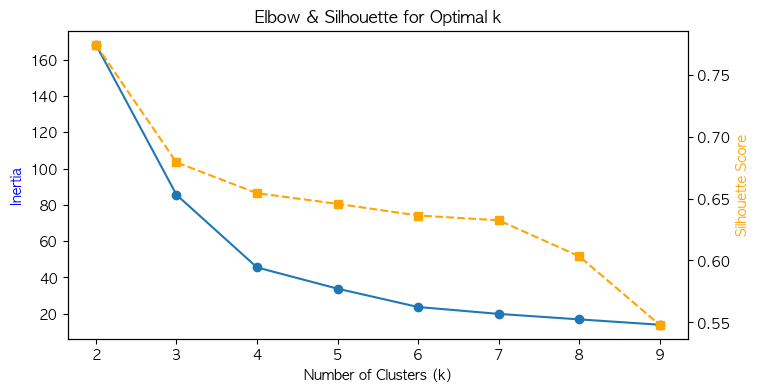

✅ 선택된 k = 4


Cluster
0    70
2    32
1    10
3     5
Name: count, dtype: int64

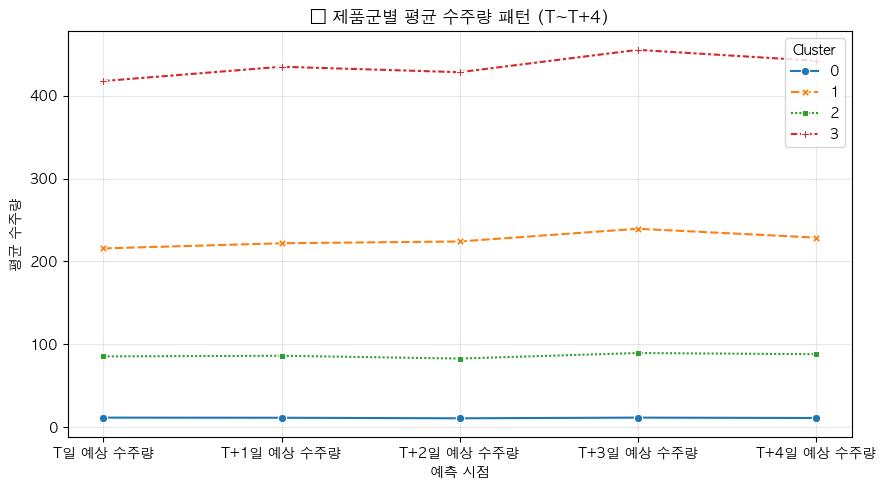

T일 예상 수주량             T+1일 예상 수주량             T+2일 예상 수주량  \
               mean         std        mean         std        mean   
Cluster                                                               
0         12.553426   23.317200   12.243036   23.378037   11.585706   
1        204.163934  167.578826  214.813115  163.060027  218.261202   
2         85.486783   86.805657   86.258607   81.886337   82.878279   
3        417.578361  283.617108  434.840000  273.214227  428.257049   

                    T+3일 예상 수주량             T+4일 예상 수주량              
                std        mean         std        mean         std  
Cluster                                                              
0         22.718242   12.458723   23.083412   11.997407   24.621380  
1        168.540524  235.218579  173.109726  237.990984  172.156858  
2         81.502576   89.565779   82.036924   88.159939   88.752465  
3        270.446201  455.200000  235.513222  442.028852  230.888457

In [37]:
# =====================================
# 📦 1. 라이브러리
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =====================================
# 🧹 3. 전처리
# =====================================
# 날짜형 변환
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# 이상치 절단
if "Humidity" in df.columns:
    df["Humidity"] = df["Humidity"].clip(lower=0, upper=100)

# 예측 수주량 컬럼만 선택 (T~T+4)
pattern_cols = [c for c in df.columns if "예상 수주량" in c]
if not pattern_cols:
    raise ValueError("예상 수주량 컬럼을 찾을 수 없습니다.")

# =====================================
# 🧩 4. 제품별 평균 패턴 계산
# =====================================
prod_pattern = df.groupby("Product_Number")[pattern_cols].mean()
print(f"✅ 제품 수: {len(prod_pattern)}개")
display(prod_pattern.head())

# =====================================
# ⚙️ 5. 정규화
# =====================================
scaler = StandardScaler()
scaled = scaler.fit_transform(prod_pattern)

# =====================================
# 🔍 6. 최적 군집 수 탐색 (Elbow + Silhouette)
# =====================================
inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(scaled)
    inertias.append(kmeans_tmp.inertia_)
    sil_scores.append(silhouette_score(scaled, labels_tmp))

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(K_range, inertias, 'o-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='blue')
ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, 's--', color='orange', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='orange')
plt.title("Elbow & Silhouette for Optimal k")
plt.show()

# =====================================
# 🚀 7. KMeans 클러스터링 (적정 k 선택)
# =====================================
optimal_k = 4  # elbow/silhouette 보고 수정 가능
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
prod_pattern["Cluster"] = kmeans.fit_predict(scaled)

print(f"✅ 선택된 k = {optimal_k}")
display(prod_pattern["Cluster"].value_counts())

# =====================================
# 📊 8. 군집별 평균 패턴 시각화
# =====================================
cluster_means = prod_pattern.groupby("Cluster")[pattern_cols].mean()

plt.figure(figsize=(9,5))
sns.lineplot(data=cluster_means.T, markers=True)
plt.title("📈 제품군별 평균 수주량 패턴 (T~T+4)")
plt.xlabel("예측 시점")
plt.ylabel("평균 수주량")
plt.legend(title="Cluster", loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================
# 🧭 9. 군집별 통계 요약
# =====================================
summary = (
    df.merge(prod_pattern["Cluster"], on="Product_Number")
      .groupby("Cluster")[pattern_cols]
      .agg(["mean", "std"])
)
display(summary)

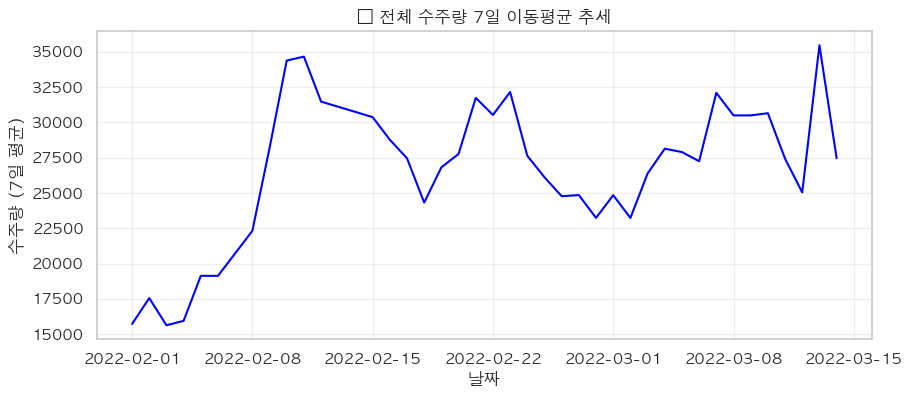

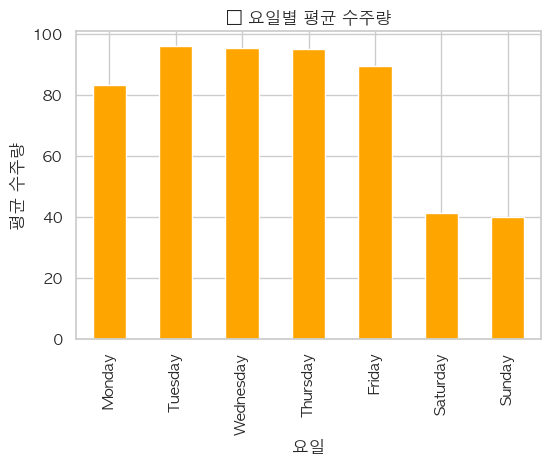

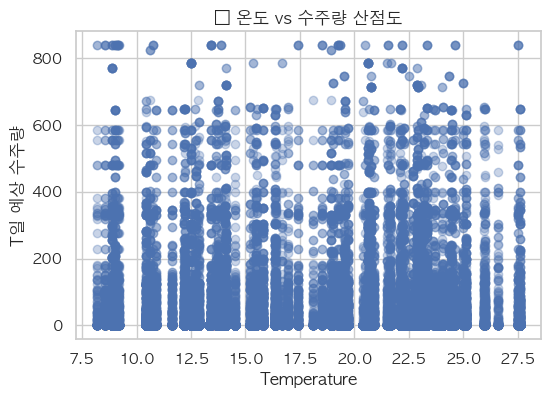

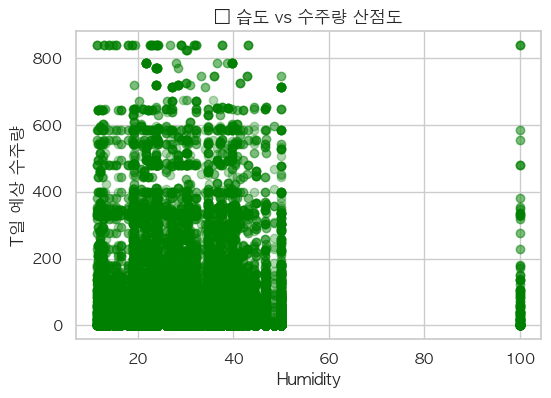

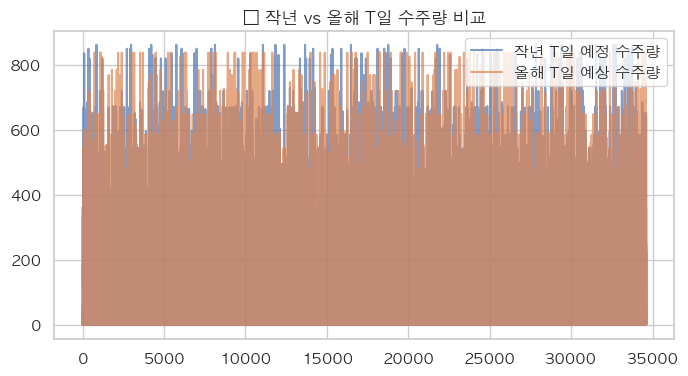

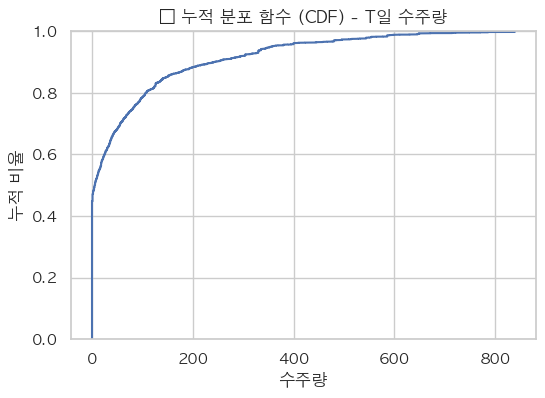

📘 제품별 기본 통계:


,mean,std,count,cv
Product_Number,,,,
Product_c0,516.701639,305.078958,305,0.590435
Product_c6,516.701639,305.078958,305,0.590435
Product_86,395.960656,229.420806,305,0.579403
Product_e0,393.042623,267.159033,305,0.679720
Product_a0,316.695082,252.962218,305,0.798756
Product_ee,265.485246,221.586966,305,0.834649
Product_a1,261.508197,210.160545,305,0.803648
Product_cb,255.501639,146.339101,305,0.572752
Product_c5,255.501639,146.339101,305,0.572752


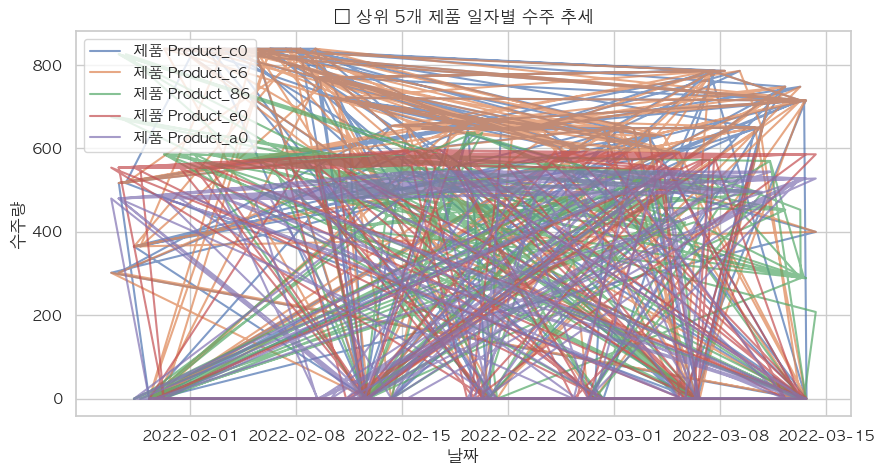

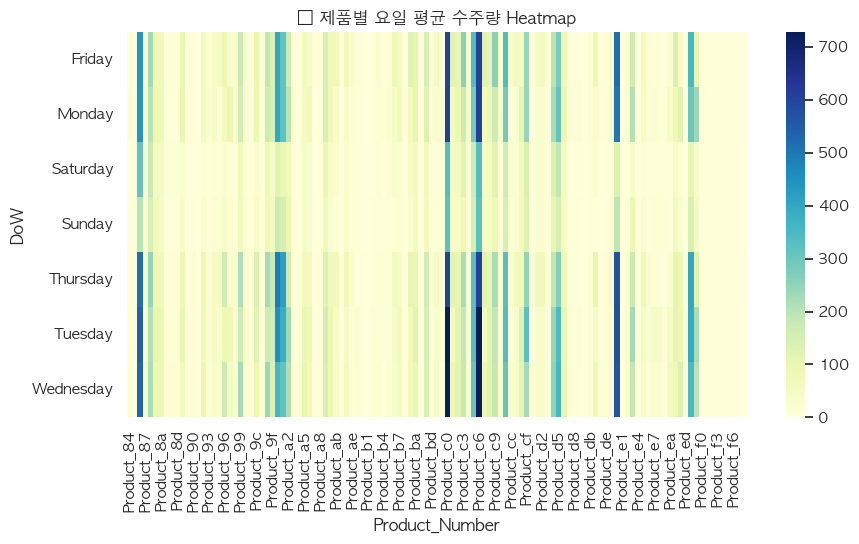

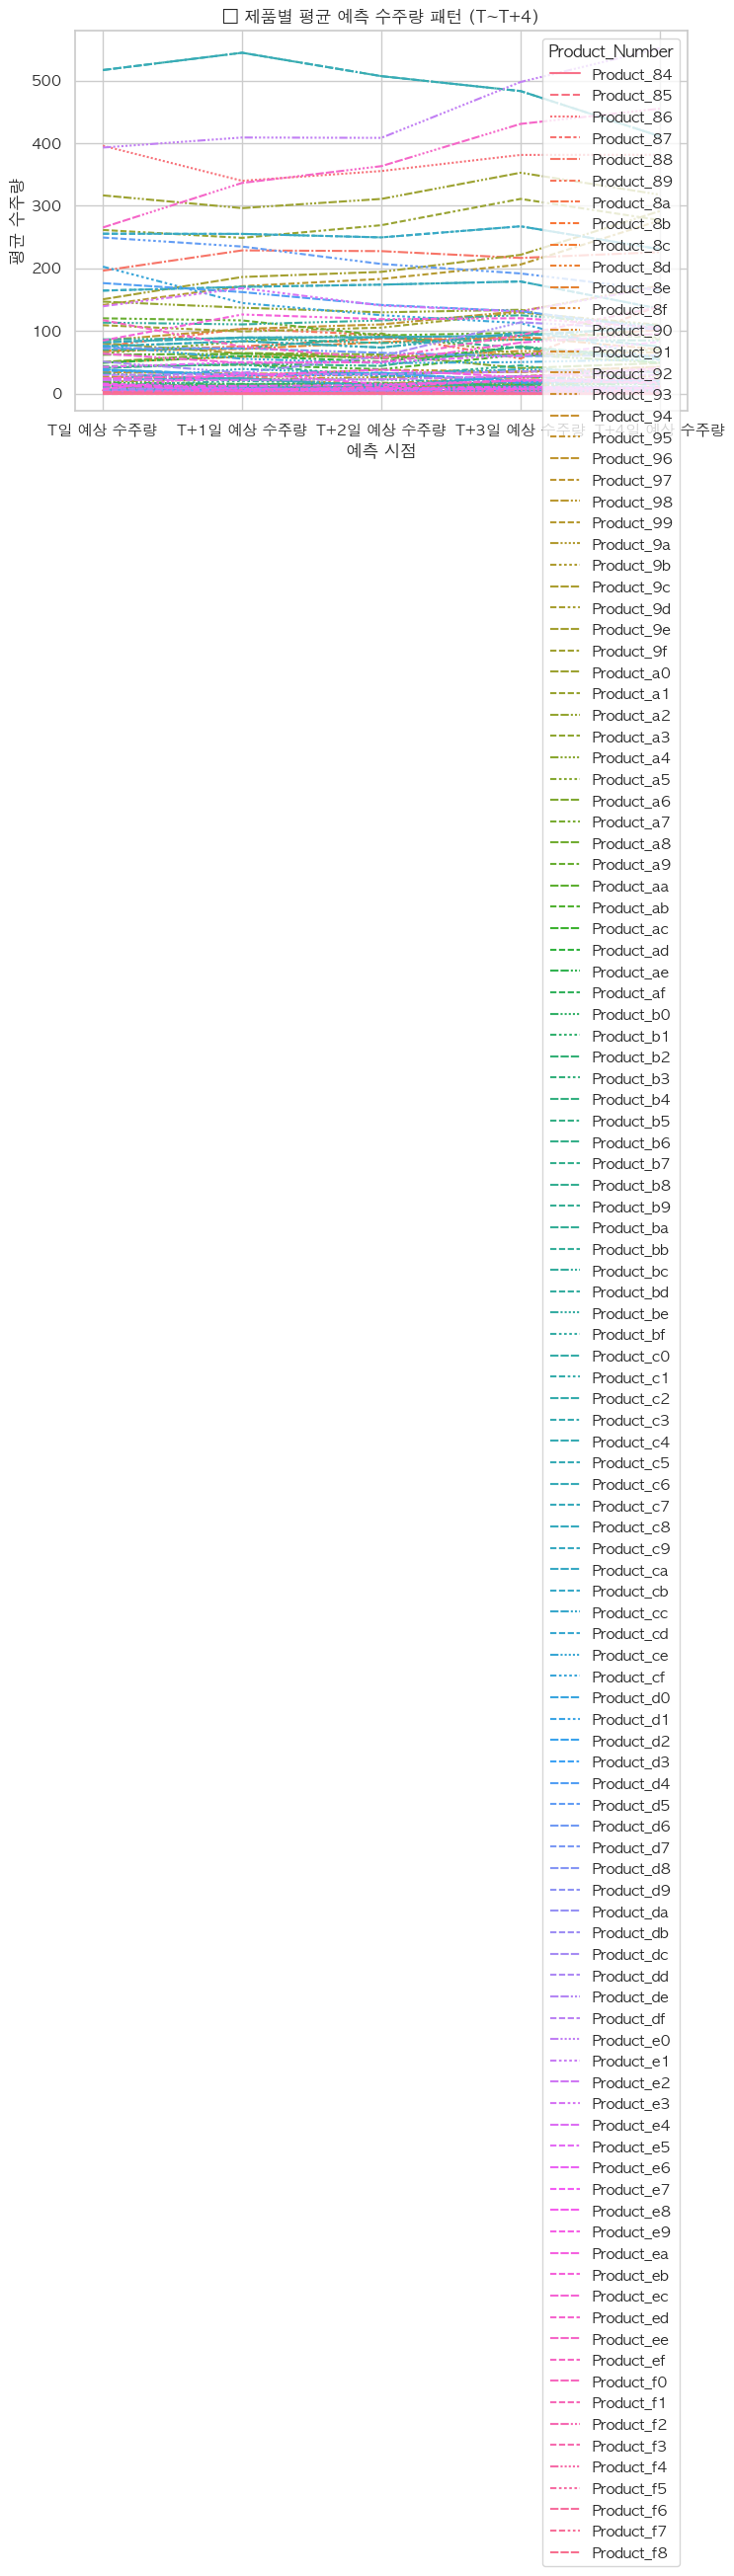

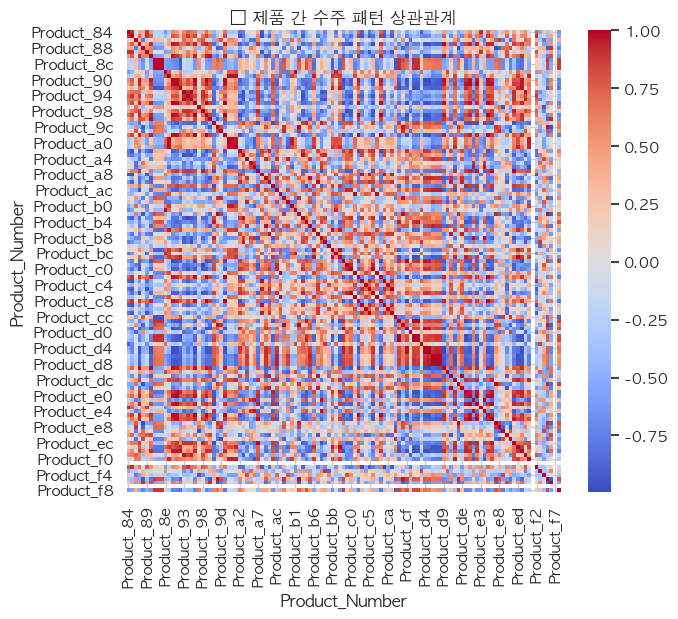

In [43]:
# =====================================
# 📦 1. 기본 설정
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================
# 📂 2. 데이터 로드
# =====================================

# 날짜형 변환
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# 요일 추가
if "DateTime" in df.columns:
    df["DoW"] = df["DateTime"].dt.day_name()

# 타깃 변수
target_col = "T일 예상 수주량"

# =====================================
# 🌐 3. 전역 시계열 EDA
# =====================================

## ① 시계열 추세 (rolling mean)
daily_sum = df.groupby(df["DateTime"].dt.date)[target_col].sum()
plt.figure(figsize=(10,4))
daily_sum.rolling(7).mean().plot(color='blue')
plt.title("📆 전체 수주량 7일 이동평균 추세")
plt.xlabel("날짜")
plt.ylabel("수주량 (7일 평균)")
plt.grid(alpha=0.3)
plt.show()

## ② 요일별 패턴
plt.figure(figsize=(6,4))
df.groupby("DoW")[target_col].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind="bar", color="orange")
plt.title("📅 요일별 평균 수주량")
plt.xlabel("요일")
plt.ylabel("평균 수주량")
plt.show()

## ③ 온도/습도 영향
plt.figure(figsize=(6,4))
plt.scatter(df["Temperature"], df[target_col], alpha=0.3)
plt.title("🌡 온도 vs 수주량 산점도")
plt.xlabel("Temperature")
plt.ylabel("T일 예상 수주량")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["Humidity"], df[target_col], alpha=0.3, color="green")
plt.title("💧 습도 vs 수주량 산점도")
plt.xlabel("Humidity")
plt.ylabel("T일 예상 수주량")
plt.show()

## ④ 작년 vs 올해 비교
prev_cols = [c for c in df.columns if "작년" in c and "예정 수주량" in c]
if prev_cols:
    plt.figure(figsize=(8,4))
    plt.plot(df[prev_cols[0]], label="작년 T일 예정 수주량", alpha=0.7)
    plt.plot(df[target_col], label="올해 T일 예상 수주량", alpha=0.7)
    plt.legend()
    plt.title("📉 작년 vs 올해 T일 수주량 비교")
    plt.show()

## ⑤ 누적 분포 (CDF)
plt.figure(figsize=(6,4))
sns.ecdfplot(df[target_col])
plt.title("📊 누적 분포 함수 (CDF) - T일 수주량")
plt.xlabel("수주량")
plt.ylabel("누적 비율")
plt.show()


# =====================================
# 🏭 4. 제품 단위 EDA
# =====================================

## ① 제품별 기본 통계
prod_stats = df.groupby("Product_Number")[target_col].agg(["mean","std","count"])
prod_stats["cv"] = prod_stats["std"] / prod_stats["mean"]
print("📘 제품별 기본 통계:")
display(prod_stats.sort_values("mean", ascending=False).head(10))

## ② 상위 5개 제품 일자별 추세
top5 = prod_stats.sort_values("mean", ascending=False).head(5).index
plt.figure(figsize=(10,5))
for p in top5:
    sub = df[df["Product_Number"] == p]
    plt.plot(sub["DateTime"], sub[target_col], label=f"제품 {p}", alpha=0.7)
plt.legend()
plt.title("📈 상위 5개 제품 일자별 수주 추세")
plt.xlabel("날짜")
plt.ylabel("수주량")
plt.show()

## ③ 제품별 요일 패턴
pivot = pd.pivot_table(df, index="DoW", columns="Product_Number", values=target_col, aggfunc="mean")
plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("📅 제품별 요일 평균 수주량 Heatmap")
plt.show()

## ④ 평균 시계열 패턴 (T~T+4)
pattern_cols = [c for c in df.columns if "예상 수주량" in c]
prod_pattern = df.groupby("Product_Number")[pattern_cols].mean()
plt.figure(figsize=(8,5))
sns.lineplot(data=prod_pattern.T)
plt.title("📈 제품별 평균 예측 수주량 패턴 (T~T+4)")
plt.xlabel("예측 시점")
plt.ylabel("평균 수주량")
plt.show()

## ⑤ 제품 간 유사도 (상관 히트맵)
corr = prod_pattern.T.corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("🔗 제품 간 수주 패턴 상관관계")
plt.show()

## ⑥ 군집 결과 해석 (이전 단계 클러스터 결과와 연동)
if "Cluster" in prod_pattern.columns:
    cluster_means = prod_pattern.groupby("Cluster")[pattern_cols].mean()
    plt.figure(figsize=(9,5))
    sns.lineplot(data=cluster_means.T, markers=True)
    plt.title("🏷️ 군집별 평균 수주 패턴 (T~T+4)")
    plt.xlabel("예측 시점")
    plt.ylabel("평균 수주량")
    plt.show()

🌐 [전역 시계열 EDA]

① 전체 수주량 7일 이동평균 추세

📊 해석:
- 2월 초반에는 수주량이 약 1.5만 → 3.5만 이상으로 급등함.
- 이후 2월 중순~말에는 약간의 변동성을 보이며 2.5~3만 선 유지.
- 3월 초에는 일시적으로 감소했다가 3월 중순 재상승.
👉 즉, 2월 초의 급격한 수요 확장 이후 완만한 안정 국면 진입으로 볼 수 있습니다.
→ 생산 및 재고계획 측면에서는 2월 초 수요 피크 구간이 중요 포인트입니다.

② 요일별 평균 수주량

📅 해석:
- 화요일목요일이 최고 수요 요일(평균 95100 수준)
- 금요일 약간 감소, 주말(토·일)은 수요 급락 (평균 40 이하)
👉 전형적인 평일 중심 수요 집중 구조.
→ 생산 스케줄링 시 평일 집중형 배치 전략이 유효합니다.
(예: 주중 생산 집중, 주말 유지보수 or 로드밸런싱용 조정)

③ 온도 vs 수주량

🌡 해석:
- 온도 10~20도 구간에 수주량이 넓게 분포 (800까지 존재)
- 뚜렷한 상관관계(선형적 관계)는 없음.
→ 수주량은 온도 변화에 민감하지 않음,
즉 온도보다는 내부 요인(예정 수주량, 제품특성, 요일 등)이 주 영향 요인임을 의미합니다.

④ 습도 vs 수주량

💧 해석:
- 습도 0~40% 사이에 대부분 몰려 있으며,
100% 근처 일부 극단값(outlier)이 존재하지만 패턴은 거의 일정.
→ 습도 역시 수요 변동에 영향이 거의 없는 요인으로 해석 가능.
→ 다만 100% 부근의 이상치는 센서 오류나 입력값 잘못 기록 가능성 높음.

⑤ 작년 vs 올해 T일 수주량 비교

📈 해석:
- 두 라인이 거의 동일한 형태를 유지하면서 미세한 차이만 보임.
→ 즉, 올해의 수주 패턴이 작년과 매우 유사하게 반복됨.
- 이는 시즌성(Seasonality) 이 존재함을 시사합니다.
→ 이후 모델링 시 “작년 대비 증감률”을 Feature로 추가하면 성능 향상 여지가 있습니다.

⑥ 누적 분포 함수(CDF)

📊 해석:
- 수주량의 약 80% 이상이 400 이하, 상위 10%만 600 이상.
→ 전형적인 Right-skewed (우측 꼬리형) 분포로,
극단적 대량 수주 제품이 일부 존재합니다.
→ 상위 10% 수요를 별도 그룹으로 관리하는 것이 효과적입니다.
(예: 고수요군 vs 일반군 분리 학습)

🏭 [제품 단위 EDA]

⑦ 상위 5개 제품 일자별 수주 추세

📈 해석:
- 전체적으로 강한 변동성.
- 각 제품은 공통적으로 “2월 초~중순에 수요 피크”를 보이고 이후 완만한 하락.
- 일부 제품은 주기적인 진동(week 단위) 패턴.
→ 즉, 상위 제품들도 개별적으로 시즌성이 존재,
생산 계획 시 주기적 피크 타이밍을 고려할 필요 있음.

⑧ 제품별 요일 평균 수주량 Heatmap

🔥 해석:
- 대부분의 제품이 평일(특히 수·목요일)에 짙은 색(높은 수주량).
- 주말(토·일)은 거의 흰색에 가까워 거의 수주 없음.
→ 제품별로 차이는 크지 않지만, 일부 제품군(Product_c6, Product_bd 등)은
요일 민감도가 뚜렷 — “요일별 생산 최적화”에 반영할 가치 있음.
→ 예: 주중 수요 대응형 제품 vs 주말 완충형 제품 분리 가능.

⑨ 제품별 평균 예측 수주량 패턴 (T~T+4)

📈 해석:
- 대부분 제품은 T일 이후로 수주량이 점차 감소하는 “하향형 패턴”
- 일부 제품은 T+3~T+4에서 수주가 늘어나는 “후반 집중형 패턴” 존재
→ 즉, 제품별로 리드타임(Lead Time) 차이가 존재함.
- 빠른 수요형 (즉시 생산형)
- 지연형 (예약·납기 중심형)
→ 클러스터링으로 이런 제품군을 “초반형 vs 후반형 vs 안정형”으로 나눌 수 있습니다.

⑨ 제품간 수주 패턴 상관관계 (T~T+4)

1.  대각선(red line)
- 자기 자신과의 상관이라 1(진한 빨강)
- 이는 모든 제품이 자기 패턴과 100% 동일하다는 것을 의미 (당연함).

2.	부분적으로 붉은색 덩어리(Cluster-like zones)
- 몇몇 제품군끼리 상관이 높게(0.6~0.9) 나타나는 구간이 존재함.
- 예를 들어, Product_bx ~ Product_cf 구간, Product_d0 ~ Product_e4 구간 등이 붉게 띄는 부분은 서로 비슷한 시점에 수요가 오르내리는 동조형 패턴을 가짐.
- 이 그룹들은 동일 고객군 혹은 동일 제품군(예: 같은 계열 생산라인)일 가능성이 높음.

3.	파란색 블록들 (음의 상관관계)
- 일부 제품군은 수요가 반대로 움직이는 경향을 보임 (예: 한 제품의 수요가 오를 때 다른 제품은 줄어듦).
- 이는 대체재(substitute) 관계 또는 공정 경쟁(product cannibalization) 가능성을 시사.
- 예: Product_9a가 오를 때 Product_b4가 떨어지는 식의 구조일 수 있음.

4.	전체적으로 희미한 색조 (붉고 파란색이 섞여 있음)
- 전반적인 상관성이 높지 않다는 뜻. 즉, 제품별로 패턴이 독립적이며, 뚜렷한 공통 리듬이 존재하지 않음.
- 이는 제품 특성·라인별 수요 패턴이 다양함을 의미하고, 단일 모델보다는 제품군 단위 예측 모델(군집 기반)이 더 적합함을 시사합니다.

✅ 예정 기준 컬럼: ['T일 예정 수주량', 'T+1일 예정 수주량', 'T+2일 예정 수주량', 'T+3일 예정 수주량', 'T+4일 예정 수주량']
✅ 예상 기준 컬럼(존재 시): ['T일 예상 수주량', 'T+1일 예상 수주량', 'T+2일 예상 수주량', 'T+3일 예상 수주량', 'T+4일 예상 수주량']
✅ 파생변수 생성 완료. 총 25개
✨ 선택된 피처: ['peak_pos']
✨ 최적 k = 4 / silhouette = 0.991

[라벨 분포]
PatternLabel
후반형    117
Name: count, dtype: int64

[군집 요약(선택 피처 평균)]
   PatternLabel  Cluster  peak_pos
0          후반형        0       0.0
1          후반형        1       4.0
2          후반형        2       1.0
3          후반형        3       2.0


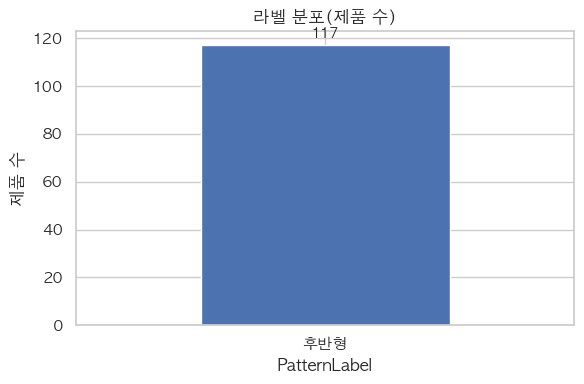


✅ 최종 파생변수 테이블 크기: (117, 30)


In [63]:
# =========================================
# 📦 0) 라이브러리
# =========================================
import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------------------
# 유틸: T, T+N 컬럼 정렬 헬퍼
# -----------------------------------------
def horizon_idx(col: str, keyword="예정"):
    if "작년" in col: 
        return 999
    m0 = re.search(fr"^T일\s*{keyword}\s*수주량", col)
    mN = re.search(fr"^T\+(\d+)일\s*{keyword}\s*수주량", col)
    if m0: return 0
    if mN: return int(mN.group(1))
    return 999

def find_horizon_cols(df, keyword="예정", max_h=4):
    cols_all = [c for c in df.columns if (f"{keyword} 수주량" in c and "작년" not in c)]
    cols_all = sorted(cols_all, key=lambda c: horizon_idx(c, keyword))
    cols = [c for c in cols_all if horizon_idx(c, keyword) in list(range(0, max_h+1))]
    return cols

# -----------------------------------------
# 1) 입력 컬럼 탐지 (기준은 '예정 수주량' / 예상 있으면 추적)
# -----------------------------------------
planned_cols = find_horizon_cols(df, keyword="예정", max_h=4)
assert len(planned_cols) >= 3, f"T~T+4 '예정 수주량' 컬럼이 부족합니다: {planned_cols}"

expected_cols = []
tmp = find_horizon_cols(df, keyword="예상", max_h=4)
if tmp:
    # planned와 순서 매칭(동일 horizon 기준)
    exp_map = {}
    for pc in planned_cols:
        h = horizon_idx(pc, "예정")
        for ec in tmp:
            if horizon_idx(ec, "예상") == h:
                exp_map[pc] = ec
                break
    expected_cols = [exp_map[pc] for pc in planned_cols if pc in exp_map]
print(f"✅ 예정 기준 컬럼: {planned_cols}")
print(f"✅ 예상 기준 컬럼(존재 시): {expected_cols}")

# -----------------------------------------
# 2) 제품별 집계(평균) 테이블
# -----------------------------------------
g = df.groupby("Product_Number", as_index=True)
planned_mean = g[planned_cols].mean().replace([np.inf, -np.inf], np.nan).fillna(0)

# 비율 패턴(합=1)과 레벨(규모) 분리
row_sum = planned_mean.sum(axis=1).replace(0, np.nan)
pattern_ratio = planned_mean.div(row_sum, axis=0).fillna(0)
pattern_ratio.columns = [f"ratio::{c}" for c in planned_mean.columns]

# -----------------------------------------
# 3) 🔧 예측에 쓰일 파생변수 생성
#     (규모/안정성/앞뒤 집중/기울기/피크/엔트로피/예상-예정 오차)
# -----------------------------------------
def front_back_share(r, front=(0,1), back=(3,4)):
    # r: 길이 5 비율 벡터
    f = sum(r[i] for i in front if i < len(r))
    b = sum(r[i] for i in back if i < len(r))
    return f, b, b - f

def entropy(p):
    p = np.array(p, float)
    p = p / (p.sum() + 1e-12)
    p = p[p > 0]
    return -float(np.sum(p * np.log(p)))

feat = pd.DataFrame(index=planned_mean.index)

# 규모/안정성
feat["level_total"] = planned_mean.sum(axis=1)
feat["level_mean"]  = planned_mean.mean(axis=1)
feat["level_max"]   = planned_mean.max(axis=1)
feat["level_std"]   = planned_mean.std(axis=1)
feat["level_cv"]    = (feat["level_std"] / feat["level_mean"]).replace([np.inf, -np.inf], 0).fillna(0)

# 패턴 기반
ratio_vals = pattern_ratio.values
feat["peak_pos"]    = ratio_vals.argmax(axis=1)                    # 0~4
feat["peak_ratio"]  = ratio_vals.max(axis=1)
feat["slope_0_4"]   = ratio_vals[:, -1] - ratio_vals[:, 0]
feat["slope_0_2"]   = ratio_vals[:, 2] - ratio_vals[:, 0]
fb = np.array([front_back_share(r) for r in ratio_vals])
feat["front_share"] = fb[:,0]
feat["back_share"]  = fb[:,1]
feat["back_minus_front"] = fb[:,2]
feat["entropy_ratio"] = [entropy(r) for r in ratio_vals]

# 시간 구간 평균(초반/중반/후반)
feat["avg_early"]  = ratio_vals[:,0:2].mean(axis=1)  # T, T+1
feat["avg_mid"]    = ratio_vals[:,2:3].mean(axis=1)  # T+2
feat["avg_late"]   = ratio_vals[:,3:5].mean(axis=1)  # T+3, T+4

# 예상 vs 예정 차이(있을 때만)
if len(expected_cols) == len(planned_cols) and len(planned_cols) > 0:
    exp_mean = g[expected_cols].mean().reindex(planned_mean.index).fillna(0)
    diff = (exp_mean.values - planned_mean.values)
    ratio = np.divide(exp_mean.values, planned_mean.values, out=np.zeros_like(exp_mean.values), where=planned_mean.values!=0)
    # 전 구간 평균/절대평균/분산 등
    feat["bias_exp_pln"]  = diff.mean(axis=1)          # 평균 편향 (예상-예정)
    feat["mae_exp_pln"]   = np.abs(diff).mean(axis=1)  # 평균 절대오차
    feat["mape_exp_pln"]  = (np.abs(ratio-1)).mean(axis=1)  # 상대오차 평균
    feat["var_ratio_ep"]  = ratio.var(axis=1)          # 구간별 비율 변동성
else:
    # 없으면 0으로(또는 NaN) 채움
    for c in ["bias_exp_pln","mae_exp_pln","mape_exp_pln","var_ratio_ep"]:
        feat[c] = 0.0

# 패턴 원본 비율(모델 투입을 원하면 keep)
feat = pd.concat([feat, pattern_ratio], axis=1)

print(f"✅ 파생변수 생성 완료. 총 {feat.shape[1]}개")

# -----------------------------------------
# 4) 📊 군집 기준(피처) 자동 탐색: 전진선택(그리디)
#     - 실루엣 스코어 최대화
# -----------------------------------------
# 후보 피처 풀(상관 중복 줄인 깔끔한 세트로 시작; 필요시 추가/제거)
candidate_pool = [
    "level_total","level_cv","peak_pos","peak_ratio","slope_0_4",
    "back_minus_front","entropy_ratio","avg_early","avg_late",
    "bias_exp_pln","mae_exp_pln","mape_exp_pln","var_ratio_ep"
]

# 존재하는 컬럼만 사용
candidate_pool = [c for c in candidate_pool if c in feat.columns]

def best_k_for_X(X, k_range=range(2, 9)):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    best_s, best_k = -1, None
    for k in k_range:
        lbl = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(Xs)
        s = silhouette_score(Xs, lbl) if len(set(lbl)) > 1 else -1
        if s > best_s:
            best_s, best_k = s, k
    return best_k, best_s

def forward_select(feat_df, pool, max_features=8, k_range=range(2,9)):
    chosen = []
    best_overall = (-1, None, None)  # (silhouette, k, chosen_list)
    while len(chosen) < max_features:
        improved = False
        best_this_round = (-1, None, None)
        for c in pool:
            if c in chosen: 
                continue
            cols = chosen + [c]
            k, s = best_k_for_X(feat_df[cols], k_range=k_range)
            if s > best_this_round[0]:
                best_this_round = (s, k, cols)
        # 갱신 판단
        if best_this_round[0] > best_overall[0] + 1e-6:
            best_overall = best_this_round
            chosen = best_this_round[2]
            pool = [c for c in pool if c not in chosen]
            improved = True
        if not improved:
            break
    return best_overall  # (silhouette, k, chosen_cols)

best_s, best_k, best_cols = forward_select(feat, candidate_pool, max_features=8, k_range=range(2,9))
print(f"✨ 선택된 피처: {best_cols}")
print(f"✨ 최적 k = {best_k} / silhouette = {best_s:.3f}")

# -----------------------------------------
# 5) 최종 군집화 실행 + 라벨링
# -----------------------------------------
Xs = StandardScaler().fit_transform(feat[best_cols])
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(Xs)
centroids = kmeans.cluster_centers_

# 해석 라벨: 초반형/후반형/안정형/T+1피크형
def human_label_by_centroid(center_vec, cols=best_cols):
    # pattern 힌트를 위해 몇 개 핵심 피처 활용
    c = dict(zip(cols, center_vec))
    slope   = c.get("slope_0_4", 0.0)
    peakpos = c.get("peak_pos",  2.0)
    peakrat = c.get("peak_ratio",0.0)
    frontback = c.get("back_minus_front", 0.0)
    entropy_ = c.get("entropy_ratio", 0.0)

    # 규칙(간단/해석 우선)
    if "avg_early" in c and "avg_late" in c:
        if c["avg_early"] > c["avg_late"] and slope < 0:
            return "초반형"
        if c["avg_late"]  > c["avg_early"] and slope > 0:
            return "후반형"

    if peakpos >= 3 and slope > 0: 
        return "후반형"
    if peakpos == 1 and peakrat > 0.35 and frontback < 0:
        return "T+1피크형"
    if abs(slope) < 0.03 and entropy_ > 1.4:
        return "안정형"
    # fallback
    return "후반형" if slope >= 0 else "초반형"

cluster_labels_h = [human_label_by_centroid(centroids[i], best_cols) for i in range(best_k)]

result = pd.DataFrame({
    "Product_Number": feat.index,
    "Cluster": labels,
    "PatternLabel": [cluster_labels_h[c] for c in labels]
}).set_index("Product_Number")

# -----------------------------------------
# 6) 결과 요약 & 시각화(간단)
# -----------------------------------------
print("\n[라벨 분포]")
print(result["PatternLabel"].value_counts())

# 군집별 피처 평균(프로파일링)
summary = (pd.concat([feat[best_cols], result], axis=1)
           .groupby(["PatternLabel","Cluster"])
           .mean()
           .reset_index())
print("\n[군집 요약(선택 피처 평균)]\n", summary.head(20))

# 간단 시각화: 라벨 분포
counts = result["PatternLabel"].value_counts()
plt.figure(figsize=(6,4))
ax = counts.plot(kind="bar")
plt.title("라벨 분포(제품 수)"); plt.ylabel("제품 수"); plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=10, xytext=(0,3), textcoords='offset points')
plt.tight_layout(); plt.show()

# -----------------------------------------
# 7) 🔁 모델 입력용 최종 파생변수 테이블 생성
#     (예측 모델에 바로 투입 가능: X_exog 예시)
# -----------------------------------------
X_exog = pd.concat([feat, result], axis=1)  # 모든 파생변수 + 군집/라벨
# 필요 시 one-hot
X_exog = pd.get_dummies(X_exog, columns=["PatternLabel","Cluster"], drop_first=False)

print(f"\n✅ 최종 파생변수 테이블 크기: {X_exog.shape}")
# X_exog 는 수요예측(회귀/시계열 exogenous)에서 바로 사용할 수 있음.

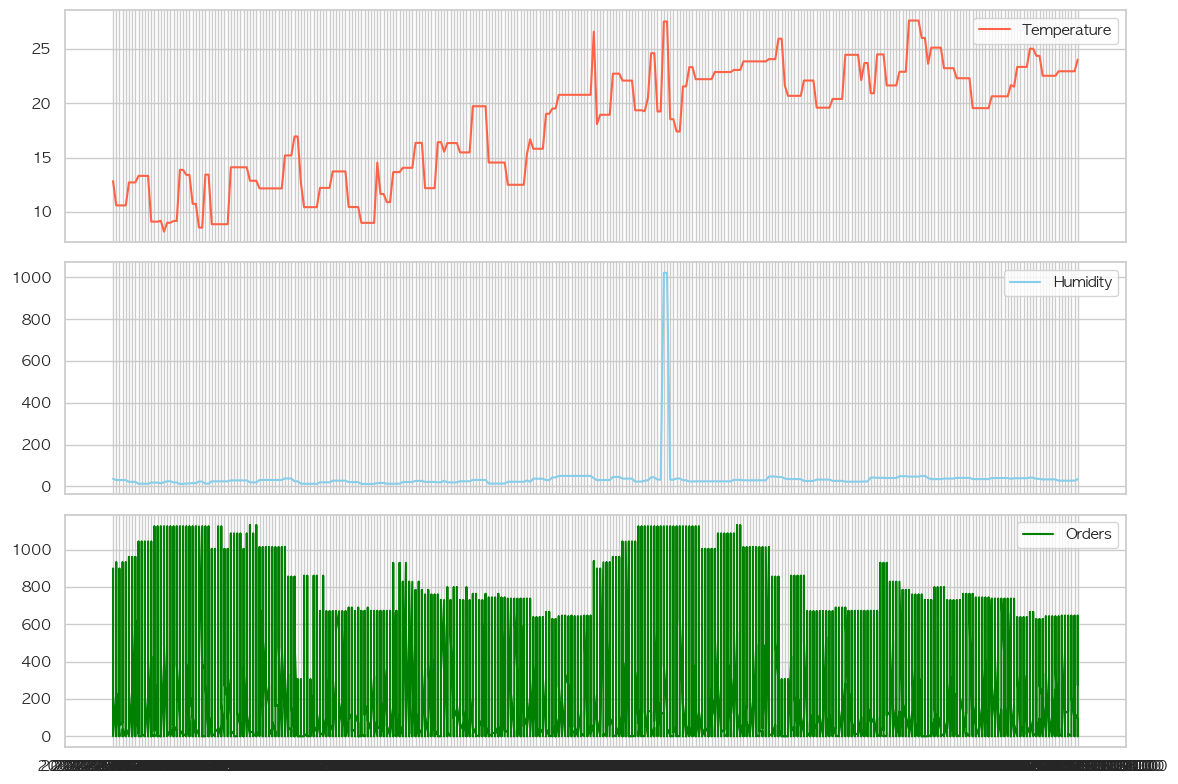

In [72]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
df_sorted = df.sort_values("DateTime")

axes[0].plot(df_sorted["DateTime"], df_sorted["Temperature"], color='tomato', label='Temperature')
axes[1].plot(df_sorted["DateTime"], df_sorted["Humidity"], color='skyblue', label='Humidity')
axes[2].plot(df_sorted["DateTime"], df_sorted["T일 예정 수주량"], color='green', label='Orders')

axes[0].legend(); axes[1].legend(); axes[2].legend()
plt.tight_layout()
plt.show()

In [74]:
dow_summary = (
    df.groupby("DoW")[["Temperature", "Humidity", "T일 예정 수주량"]]
      .mean().reset_index()
)
print(dow_summary)

         DoW  Temperature   Humidity   T일 예정 수주량
0     Friday    18.416307  27.042984   99.239963
1     Monday    16.433672  27.834446  105.898846
2   Saturday    18.321272  68.846491  105.532091
3     Sunday    18.955918  32.712812  105.411903
4   Thursday    16.143837  25.803441   94.415448
5    Tuesday    21.118068  30.538479  101.492172
6  Wednesday    16.278077  28.249205   91.064658


In [66]:
import statsmodels.formula.api as smf

model = smf.ols(
    "Q('T일 예정 수주량') ~ Temperature + Humidity + C(DoW) + Temperature*C(DoW) + Humidity*C(DoW)",
    data=df
).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('T일 예정 수주량')   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.406
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           0.000415
Time:                        17:15:56   Log-Likelihood:            -1.1359e+05
No. Observations:               17364   AIC:                         2.272e+05
Df Residuals:                   17343   BIC:                         2.274e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [67]:
for lag in range(1, 4):
    df[f"temp_lag{lag}"] = df["Temperature"].shift(lag)
    df[f"humid_lag{lag}"] = df["Humidity"].shift(lag)

corrs = df[[f"temp_lag{i}" for i in range(1,4)] + [f"humid_lag{i}" for i in range(1,4)] + ["T일 예정 수주량"]].corr()
print(corrs["T일 예정 수주량"])

temp_lag1     0.000779
temp_lag2     0.001276
temp_lag3    -0.002579
humid_lag1   -0.001040
humid_lag2    0.000105
humid_lag3    0.002521
T일 예정 수주량     1.000000
Name: T일 예정 수주량, dtype: float64


In [76]:
import pandas as pd

# Datetime 컬럼을 datetime 형식으로 변환
df['Datetime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# 시간(hour) 변수 추가
df['Hour'] = df['Datetime'].dt.hour

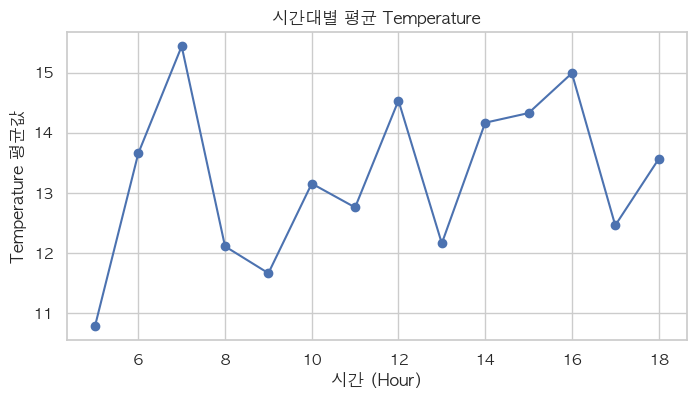

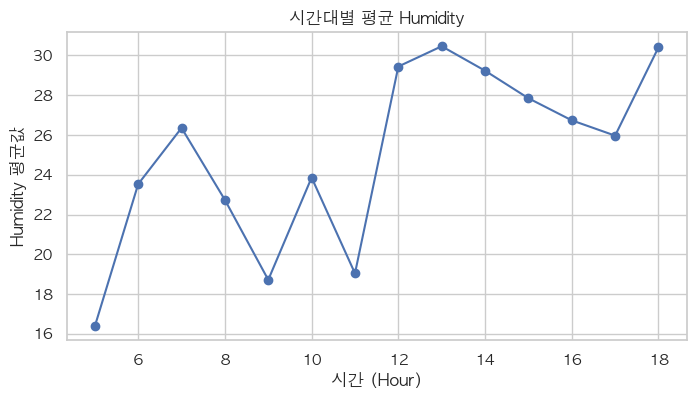

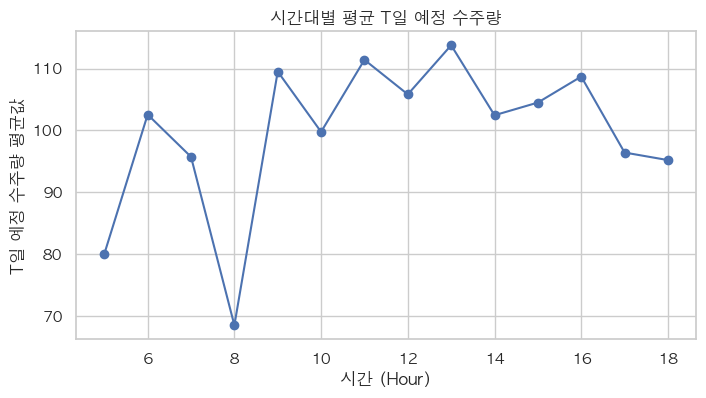

In [77]:
import matplotlib.pyplot as plt

# 주요 변수 목록 (실제 데이터 컬럼에 맞게 수정)
main_vars = ['Temperature', 'Humidity', 'T일 예정 수주량']

for col in main_vars:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        df.groupby('Hour')[col].mean().plot(marker='o')
        plt.title(f'시간대별 평균 {col}')
        plt.xlabel('시간 (Hour)')
        plt.ylabel(f'{col} 평균값')
        plt.grid(True)
        plt.show()

In [78]:
import scipy.stats as stats

for col in main_vars:
    if col in df.columns:
        groups = [group[col].dropna().values for _, group in df.groupby('Hour')]
        f, p = stats.f_oneway(*groups)
        print(f"{col} — 시간별 차이 ANOVA p-value: {p:.4f}")

Temperature — 시간별 차이 ANOVA p-value: 0.0000
Humidity — 시간별 차이 ANOVA p-value: 0.0000
T일 예정 수주량 — 시간별 차이 ANOVA p-value: 0.0013


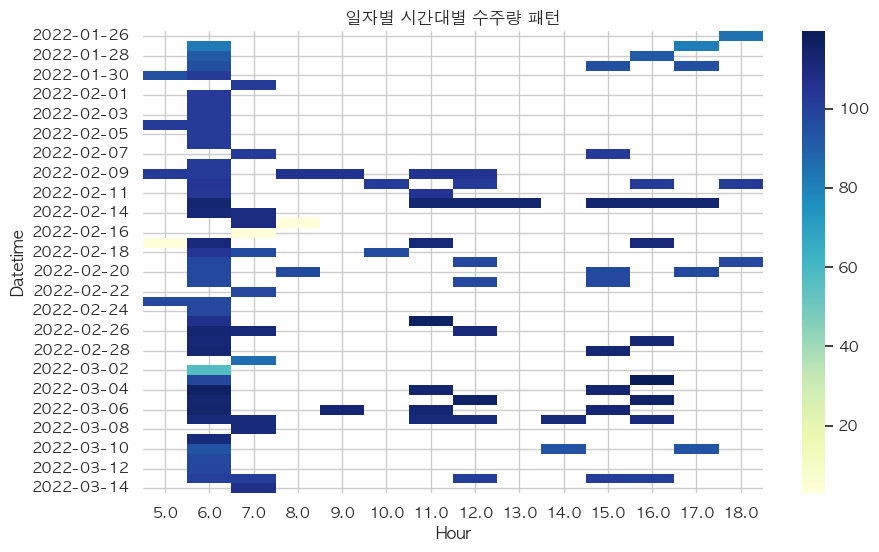

In [79]:
# 1️⃣ 상관계수 확인
df[['Hour', 'Temperature', 'Humidity', 'T일 예정 수주량']].corr()['Hour']

# 2️⃣ T일 예정 수주량 기준으로 Heatmap
import seaborn as sns
pivot = df.pivot_table(values='T일 예정 수주량', index=df['Datetime'].dt.date, columns='Hour')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("일자별 시간대별 수주량 패턴")
plt.show()

In [87]:
# 데이터 로드
# df = pd.read_csv("data.csv")

# 1. 'DateTime' 컬럼을 datetime 객체로 변환합니다.
df['DateTime'] = pd.to_datetime(df['DateTime'], format="mixed", errors="coerce")

is_duplicate_key = df.duplicated(subset=['Product_Number', 'DateTime'], keep=False)

# 3. 중복된 키(Product_Number + DateTime)를 가진 모든 원본 행을 필터링합니다.
multi_record_data = df[is_duplicate_key].sort_values(by=['Product_Number', 'DateTime']).reset_index(drop=True)

print("--- 1. Product_Number와 DateTime이 동일한 중복 기록 원본 행 추출 ---")
print(f"총 데이터 행 수: {len(df)}개")
print(f"중복된 Product_Number-DateTime 쌍에 해당하는 행 총 개수: {len(multi_record_data)}개")

# 4. 중복된 데이터를 출력합니다. (너무 길 경우 앞 50개 행만 출력)
if not multi_record_data.empty:
    print("\n--- 2. 중복 기록된 원본 데이터 (최대 50개 행) ---")
    
    # 출력 포맷을 깔끔하게 유지하기 위해 to_markdown 사용
    print(multi_record_data.head(50).to_markdown(index=False, numalign="left", stralign="left"))
    
    # 중복된 키를 가진 고유한 쌍의 개수를 다시 한번 확인합니다.
    num_unique_duplicate_pairs = multi_record_data.groupby(['Product_Number', 'DateTime']).ngroups
    print(f"\n--- 3. 중복된 고유 (Product_Number, DateTime) 쌍 개수: {num_unique_duplicate_pairs}개 ---")
    
    # 이들 쌍의 중복 정도를 확인하기 위한 통계 (각 쌍별 기록 횟수)
    record_counts = multi_record_data.groupby(['Product_Number', 'DateTime']).size().reset_index(name='Record_Count')
    print("\n--- 4. 각 중복 쌍별 기록 횟수 요약 ---")
    print(record_counts['Record_Count'].describe().to_markdown(numalign="left", stralign="left"))
    
else:
    print("\n[인사이트]: 모든 Product_Number-DateTime 쌍은 고유합니다. 동일 시간의 순수 중복은 발생하지 않았습니다.")

# 참고: 모든 컬럼이 동일한 완전 중복 행 개수 (전체 데이터에서)
full_duplicates = df[df.duplicated(keep=False)]
print(f"\n--- 5. 모든 컬럼이 동일한 완전 중복 행 개수 (참고): {len(full_duplicates)}개 ---")

--- 1. Product_Number와 DateTime이 동일한 중복 기록 원본 행 추출 ---
총 데이터 행 수: 34617개
중복된 Product_Number-DateTime 쌍에 해당하는 행 총 개수: 1442개

--- 2. 중복 기록된 원본 데이터 (최대 50개 행) ---
| Product_Number   | T일 예정 수주량   | T+1일 예정 수주량   | T+2일 예정 수주량   | T+3일 예정 수주량   | T+4일 예정 수주량   | 작년 T일 예정 수주량   | 작년 T+1일 예정 수주량   | 작년 T+2일 예정 수주량   | 작년 T+3일 예정 수주량   | 작년 T+4일 예정 수주량   | T일 예상 수주량   | T+1일 예상 수주량   | T+2일 예상 수주량   | T+3일 예상 수주량   | T+4일 예상 수주량   | DateTime            | DoW       | Temperature   | Humidity   | Datetime            | Hour   |
|:-----------------|:------------------|:--------------------|:--------------------|:--------------------|:--------------------|:-----------------------|:-------------------------|:-------------------------|:-------------------------|:-------------------------|:------------------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|:----------|:--------------|:-----------|:--------------------|:-------|
| Product_84

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PLAN_COLS     = ['T일 예정 수주량','T+1일 예정 수주량','T+2일 예정 수주량','T+3일 예정 수주량','T+4일 예정 수주량']
PLAN_LY_COLS  = ['작년 T일 예정 수주량','작년 T+1일 예정 수주량','작년 T+2일 예정 수주량','작년 T+3일 예정 수주량','작년 T+4일 예정 수주량']
PRED_COLS     = ['T일 예상 수주량','T+1일 예상 수주량','T+2일 예상 수주량','T+3일 예상 수주량','T+4일 예상 수주량']
HORIZON_LABELS= ['T','T+1','T+2','T+3','T+4']

# 가끔 문자열/콤마가 섞인 숫자 방지
def _to_float_array(row, cols):
    return pd.to_numeric(row[cols].astype(str).str.replace(',', ''), errors='coerce').to_numpy(dtype=float)

# 제품 하나를 골라서 대표 1행(또는 최근 1행) 시각화용으로 가져오기
def pick_one_row(df, product_id=None, sort_col='DateTime'):
    if product_id is None:
        sub = df.copy()
    else:
        sub = df[df['Product_Number']==product_id].copy()
    if sort_col in sub.columns:
        sub = sub.sort_values(sort_col)
    return sub.tail(1).squeeze()  # 마지막 1행

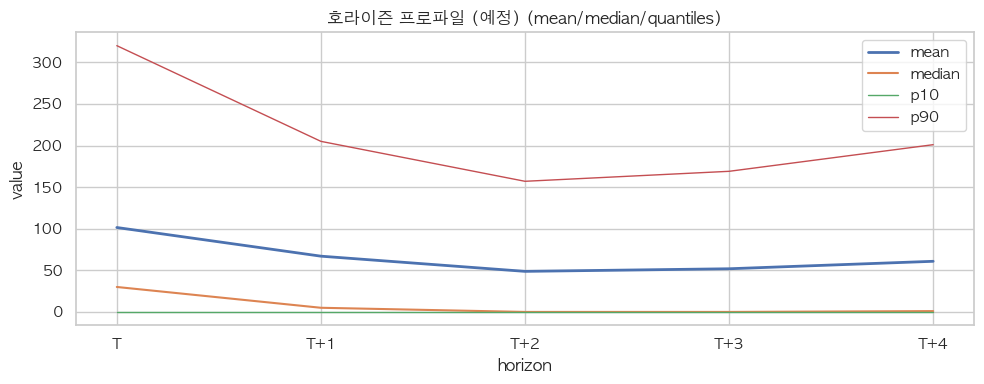

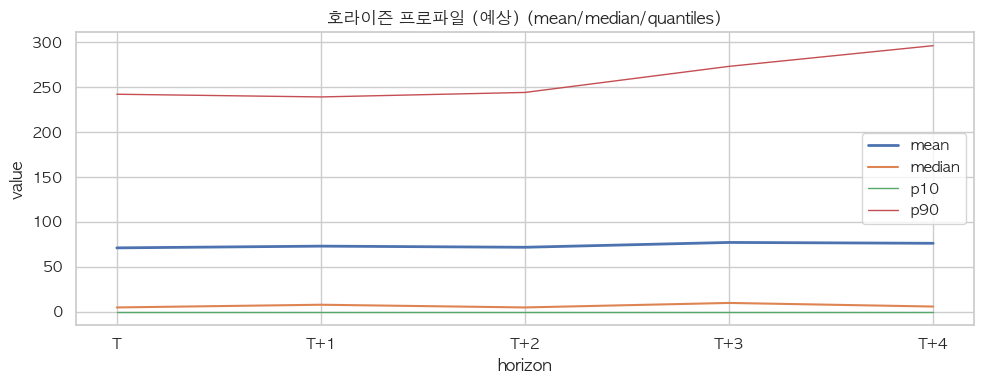

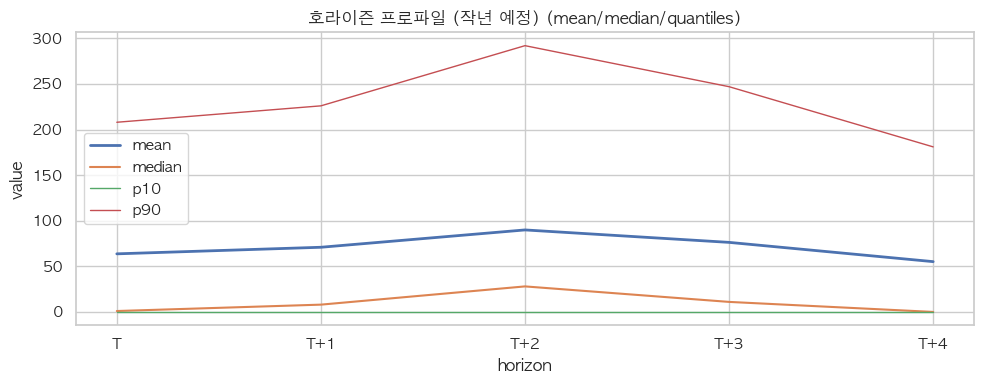

In [91]:
def plot_horizon_profile(df, value_cols, title_prefix='(예정 수주량)'):
    mat = df[value_cols].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',',''), errors='coerce')).to_numpy()
    x = np.arange(len(value_cols))

    mean = np.nanmean(mat, axis=0)
    p10  = np.nanpercentile(mat, 10, axis=0)
    p50  = np.nanpercentile(mat, 50, axis=0)
    p90  = np.nanpercentile(mat, 90, axis=0)

    plt.figure(figsize=(10,4))
    plt.plot(x, mean, label='mean', linewidth=2)
    plt.plot(x, p50,  label='median', linewidth=1.5)
    plt.plot(x, p10,  label='p10', linewidth=1)
    plt.plot(x, p90,  label='p90', linewidth=1)
    plt.xticks(x, HORIZON_LABELS)
    plt.title(f"호라이즌 프로파일 {title_prefix} (mean/median/quantiles)")
    plt.xlabel("horizon"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()

# 사용 예: 예정/예상/작년 각각 확인
plot_horizon_profile(df, PLAN_COLS,    "(예정)")
plot_horizon_profile(df, PRED_COLS,    "(예상)")
plot_horizon_profile(df, PLAN_LY_COLS, "(작년 예정)")

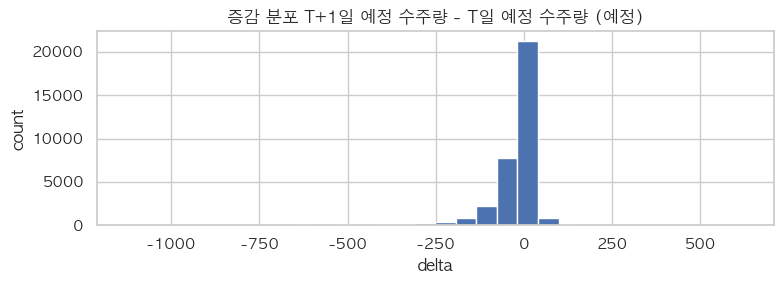

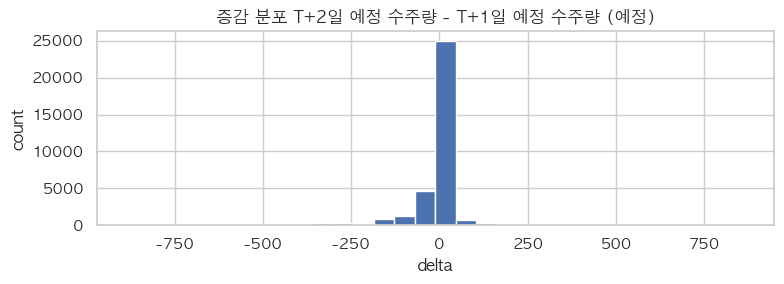

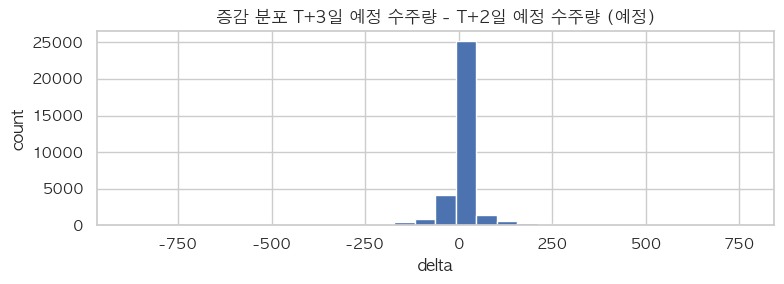

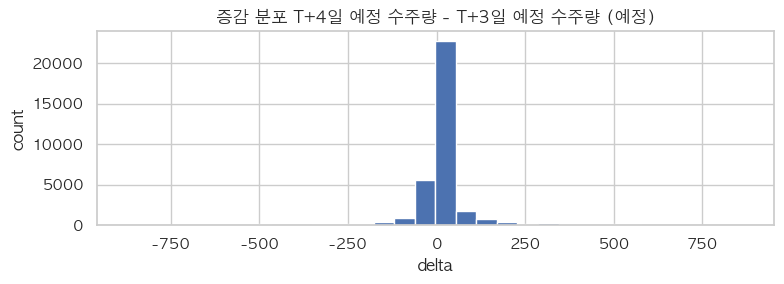

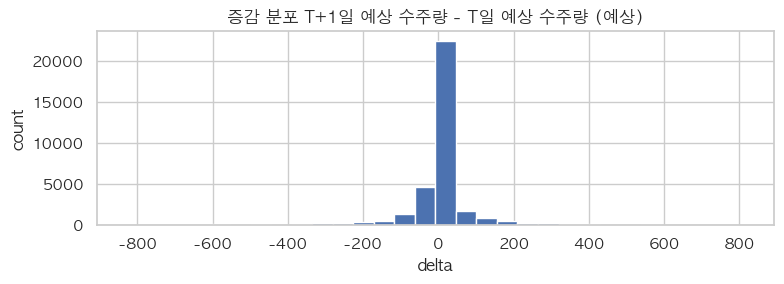

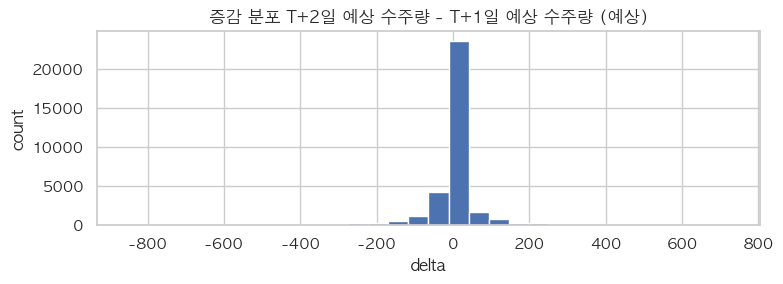

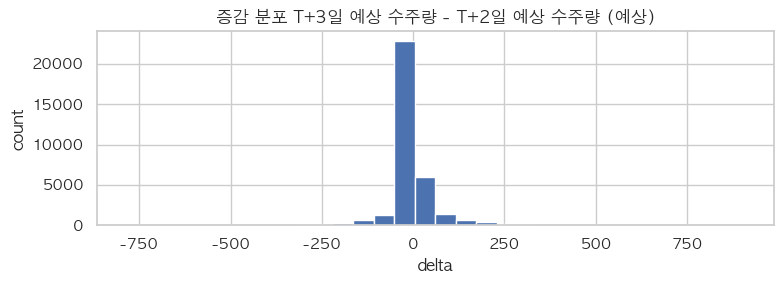

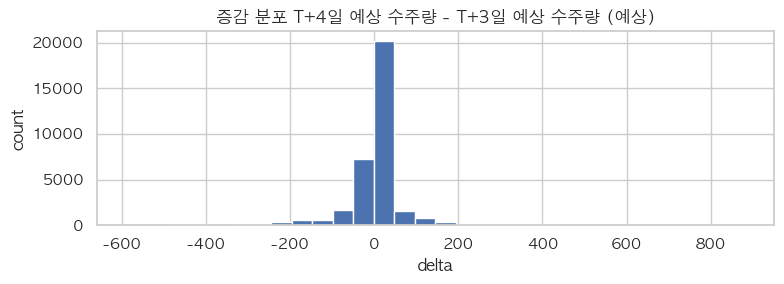

In [92]:
def plot_diff_histograms(df, value_cols, title_prefix='(예정)'):
    for i in range(len(value_cols)-1):
        a = pd.to_numeric(df[value_cols[i+1]].astype(str).str.replace(',',''), errors='coerce')
        b = pd.to_numeric(df[value_cols[i  ]].astype(str).str.replace(',',''), errors='coerce')
        d = a - b
        plt.figure(figsize=(8,3))
        plt.hist(d.dropna(), bins=30)
        plt.title(f"증감 분포 {value_cols[i+1]} - {value_cols[i]} {title_prefix}")
        plt.xlabel("delta"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# 사용 예
plot_diff_histograms(df, PLAN_COLS, "(예정)")
plot_diff_histograms(df, PRED_COLS, "(예상)")

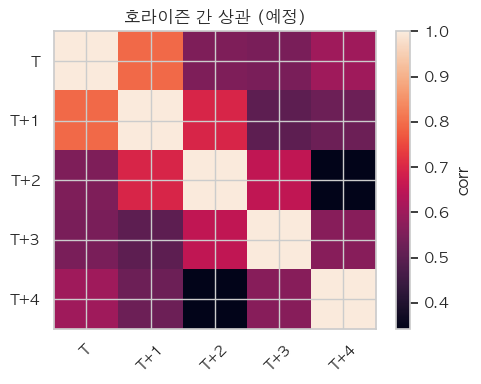

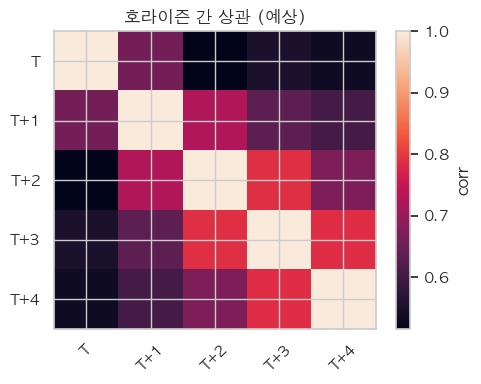

In [93]:
def plot_horizon_corr(df, value_cols, title_prefix='(예정)'):
    c = df[value_cols].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',',''), errors='coerce')).corr()
    plt.figure(figsize=(5,4))
    plt.imshow(c, aspect='auto')
    plt.colorbar(label='corr')
    plt.xticks(range(len(value_cols)), HORIZON_LABELS, rotation=45)
    plt.yticks(range(len(value_cols)), HORIZON_LABELS)
    plt.title(f"호라이즌 간 상관 {title_prefix}")
    plt.tight_layout(); plt.show()

# 사용 예
plot_horizon_corr(df, PLAN_COLS, "(예정)")
plot_horizon_corr(df, PRED_COLS, "(예상)")

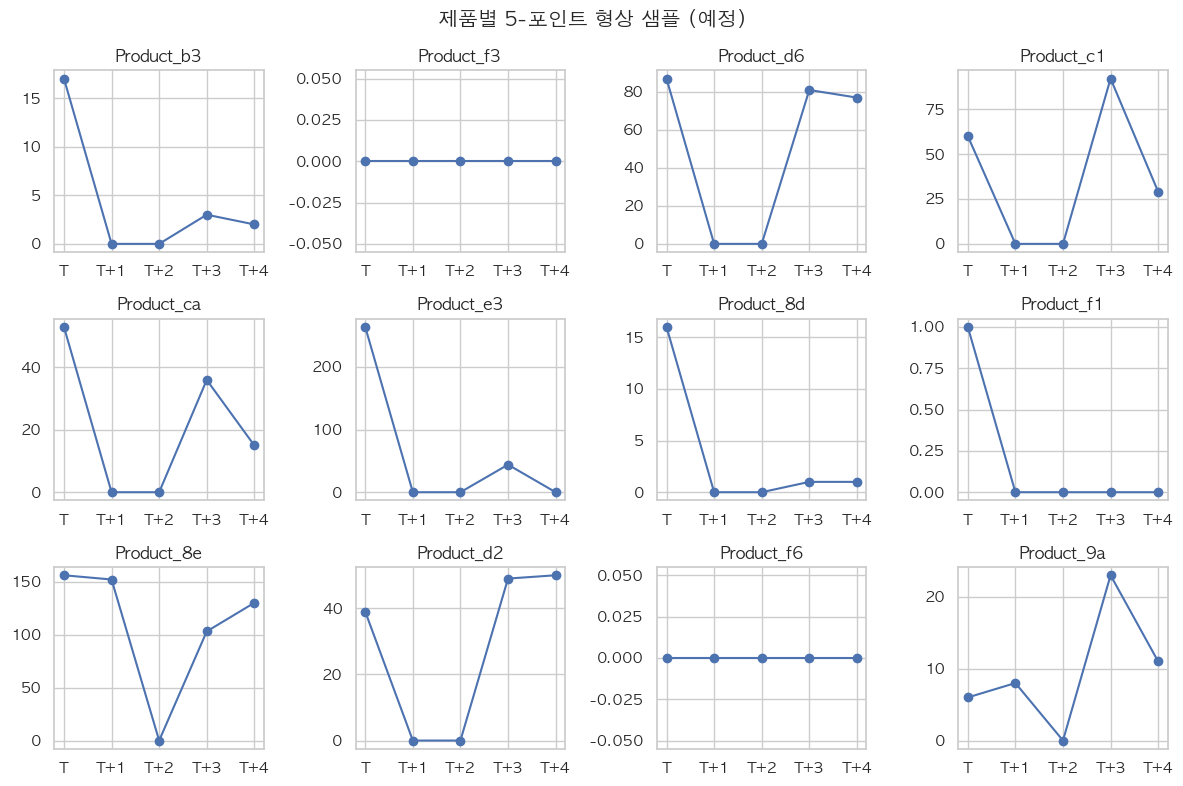

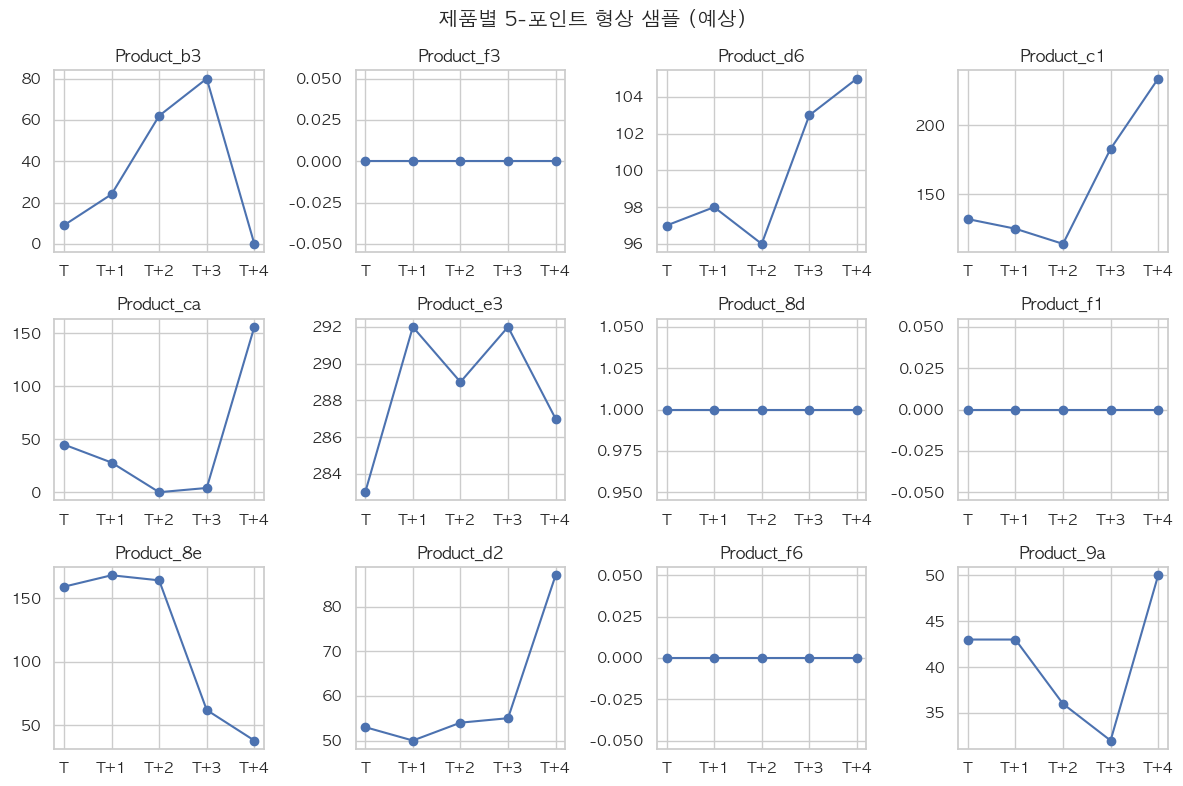

In [94]:
def plot_sample_shapes(df, value_cols, n=12, random_state=42, title_prefix='(예정)'):
    ids = df['Product_Number'].dropna().unique()
    rng = np.random.default_rng(random_state)
    pick = rng.choice(ids, size=min(n, len(ids)), replace=False)

    x = np.arange(len(value_cols))
    plt.figure(figsize=(12,8))
    rows = int(np.ceil(len(pick)/4)); cols = 4

    for i, pid in enumerate(pick, 1):
        sub = df[df['Product_Number']==pid]
        row = sub.sort_values('DateTime').tail(1) if 'DateTime' in sub.columns else sub.head(1)
        if row.empty: continue
        y = _to_float_array(row.iloc[0], value_cols)
        plt.subplot(rows, cols, i)
        plt.plot(x, y, marker='o', linewidth=1.5)
        plt.xticks(x, HORIZON_LABELS, rotation=0)
        plt.title(str(pid))
    plt.suptitle(f"제품별 5-포인트 형상 샘플 {title_prefix}")
    plt.tight_layout(); plt.show()

# 사용 예
plot_sample_shapes(df, PLAN_COLS, title_prefix="(예정)")
plot_sample_shapes(df, PRED_COLS, title_prefix="(예상)")

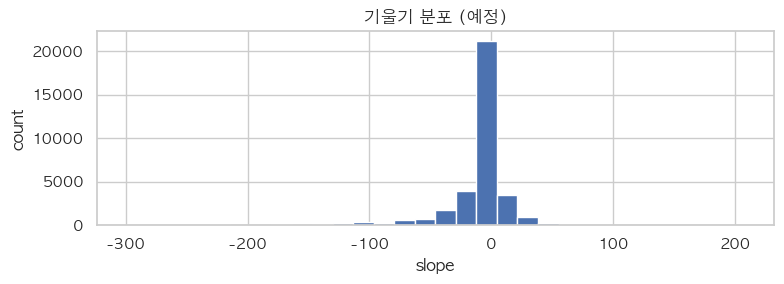

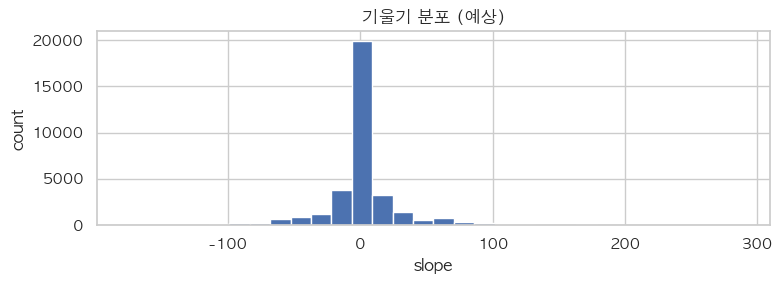

In [95]:
def plot_slope_distribution(df, value_cols, title_prefix='(예정)'):
    x = np.arange(len(value_cols))
    slopes = []
    for _, row in df.iterrows():
        y = _to_float_array(row, value_cols)
        if np.isnan(y).any(): continue
        m = np.polyfit(x, y, 1)[0]  # 1차 회귀 기울기
        slopes.append(m)
    if not slopes:
        print("유효한 샘플이 없습니다."); return
    plt.figure(figsize=(8,3))
    plt.hist(pd.Series(slopes), bins=30)
    plt.title(f"기울기 분포 {title_prefix}")
    plt.xlabel("slope"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# 사용 예
plot_slope_distribution(df, PLAN_COLS, "(예정)")
plot_slope_distribution(df, PRED_COLS, "(예상)")

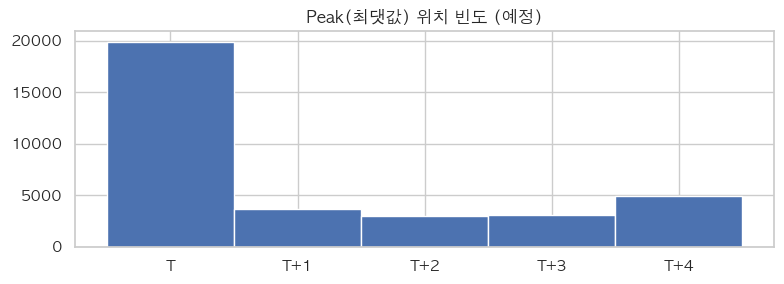

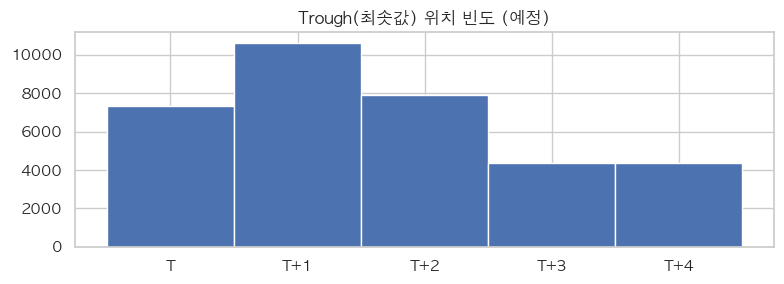

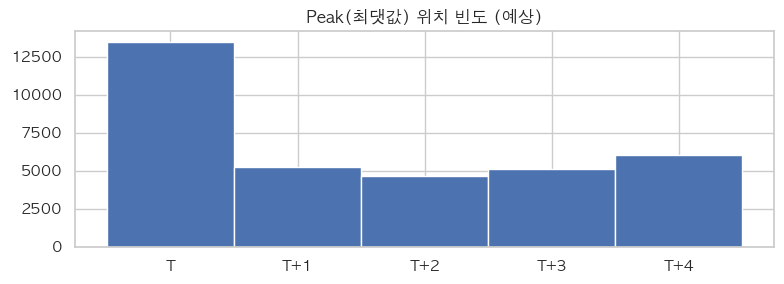

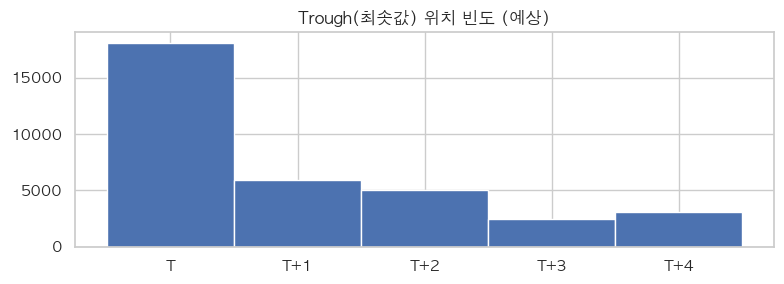

In [96]:
def plot_argextreme_positions(df, value_cols, title_prefix='(예정)'):
    argmax_pos, argmin_pos = [], []
    for _, row in df.iterrows():
        y = _to_float_array(row, value_cols)
        if np.isnan(y).any(): continue
        argmax_pos.append(int(np.argmax(y)))
        argmin_pos.append(int(np.argmin(y)))
    if not argmax_pos:
        print("유효한 샘플이 없습니다."); return

    plt.figure(figsize=(8,3))
    plt.hist(argmax_pos, bins=np.arange(-0.5, len(value_cols)+0.5, 1))
    plt.xticks(range(len(value_cols)), HORIZON_LABELS, rotation=0)
    plt.title(f"Peak(최댓값) 위치 빈도 {title_prefix}")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3))
    plt.hist(argmin_pos, bins=np.arange(-0.5, len(value_cols)+0.5, 1))
    plt.xticks(range(len(value_cols)), HORIZON_LABELS, rotation=0)
    plt.title(f"Trough(최솟값) 위치 빈도 {title_prefix}")
    plt.tight_layout(); plt.show()

# 사용 예
plot_argextreme_positions(df, PLAN_COLS, "(예정)")
plot_argextreme_positions(df, PRED_COLS, "(예상)")

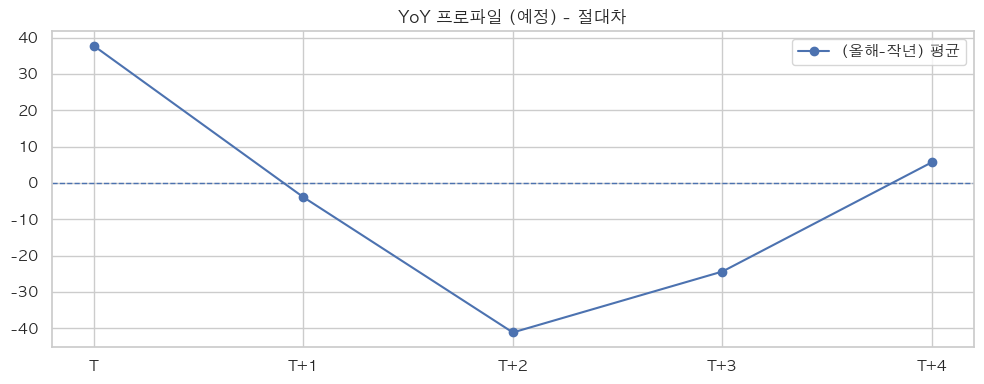

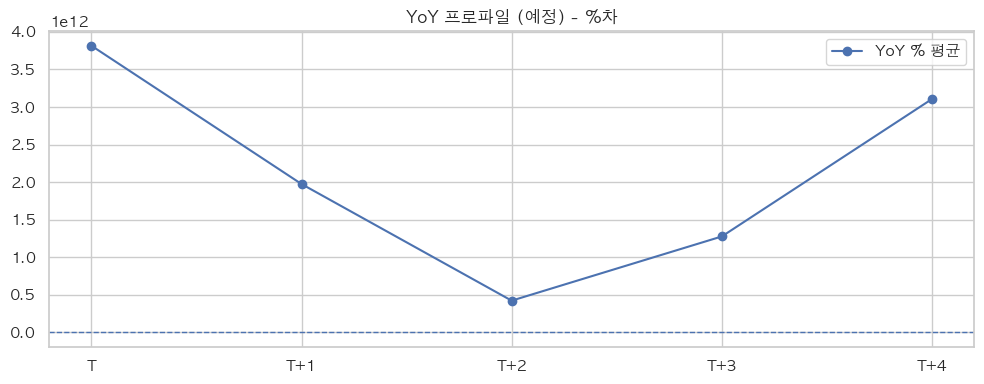

In [97]:
def plot_yoy_profile(df, this_cols, last_cols, title='YoY 프로파일 (예정)'):
    A = df[this_cols].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',',''), errors='coerce')).to_numpy()
    B = df[last_cols].apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',',''), errors='coerce')).to_numpy()

    yoy_mean = np.nanmean(A - B, axis=0)           # 절대차
    yoy_pct  = np.nanmean((A - B) / (B+1e-9), axis=0) * 100  # %차

    x = np.arange(len(this_cols))
    plt.figure(figsize=(10,4))
    plt.plot(x, yoy_mean, marker='o', label='(올해-작년) 평균')
    plt.xticks(x, HORIZON_LABELS)
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title(title + " - 절대차")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(x, yoy_pct, marker='o', label='YoY % 평균')
    plt.xticks(x, HORIZON_LABELS)
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title(title + " - %차")
    plt.legend(); plt.tight_layout(); plt.show()

# 사용 예: 예정 기준 YoY
plot_yoy_profile(df, PLAN_COLS, PLAN_LY_COLS, "YoY 프로파일 (예정)")

--- 1. 제품 클러스터링 결과 (K=4) ---
| Cluster   | count   |
|:----------|:--------|
| 1         | 72      |
| 3         | 24      |
| 0         | 15      |
| 2         | 6       |

--- 2. 클러스터별 평균 피처 (패턴 해석) ---
| Cluster   | Mean_Demand   | Std_Demand   | Zero_Ratio   | CV_Ratio   |
|:----------|:--------------|:-------------|:-------------|:-----------|
| 0         | 420.889       | 140.465      | 0.0480874    | 0.371548   |
| 1         | 63.6481       | 33.3536      | 0.0970042    | 0.691482   |
| 2         | 0.440615      | 1.58063      | 0.894323     | 4.12744    |
| 3         | 5.73774       | 9.18342      | 0.525078     | 1.55892    |

(Insight: 시각화된 클러스터 트렌드를 통해 각 그룹이 계절성, 변동성, 규모 등에서 어떻게 다른지 확인하여, 그룹별 모델링 전략을 수립합니다.)


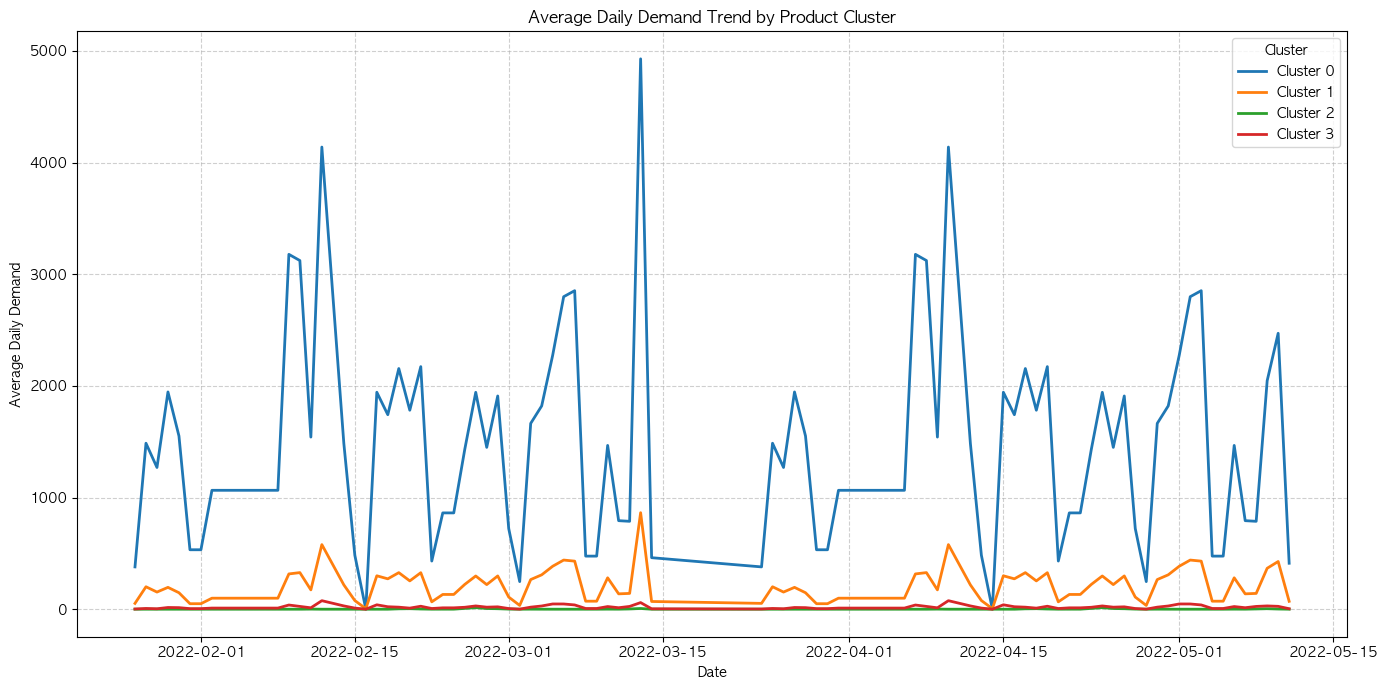

In [82]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


# T일 예정 수주량 컬럼
demand_col = 'T일 예정 수주량'

# — 1. 클러스터링을 위한 피처 추출 (제품별 통계) —
# T일 수요량만 사용하여 제품별 패턴을 대표하는 4가지 통계적 피처를 생성합니다.
product_features = df.groupby('Product_Number')[demand_col].agg(
    # 평균 수요 (스케일)
    Mean_Demand='mean',
    # 표준편차 (변동성)
    Std_Demand='std',
    # 0 수요가 발생하는 비율 (간헐성/희소성)
    Zero_Ratio=lambda x: (x == 0).mean(),
    # 변동 계수 (CV, Coefficient of Variation: 변동성/평균)
    CV_Ratio=lambda x: x.std() / x.mean() if x.mean() != 0 else 0
).fillna(0)

# CV_Ratio에서 발생하는 무한대 값 처리 (평균 수요가 0인데 표준편차가 0이 아닐 경우)
product_features.replace([np.inf, -np.inf], 0, inplace=True)


# --- 2. 데이터 표준화 ---
scaler = StandardScaler()
# 클러스터링을 위해 데이터를 표준화하여 스케일의 영향을 제거합니다.
scaled_features = scaler.fit_transform(product_features)


# --- 3. K-Means 클러스터링 수행 ---
# 그룹 개수 K=4로 설정 (예시: A(핵심), B(중), C(간헐적), D(미미))
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
product_features['Cluster'] = kmeans.fit_predict(scaled_features)

print(f"--- 1. 제품 클러스터링 결과 (K={K}) ---")
print(product_features['Cluster'].value_counts().to_markdown(numalign="left", stralign="left"))

print("\n--- 2. 클러스터별 평균 피처 (패턴 해석) ---")
# 클러스터별 평균 피처를 확인하여 각 그룹의 특성을 해석합니다.
cluster_summary = product_features.groupby('Cluster').mean()
print(cluster_summary.to_markdown(numalign="left", stralign="left"))


# --- 4. 시각화: 클러스터별 평균 수요 시계열 트렌드 ---

# 제품별 일별 평균 수요를 다시 계산하여 시계열 트렌드를 얻습니다.
# 모든 제품을 포함하되, 일자별 평균 수요로 변환
df['Date'] = df['DateTime'].dt.date
daily_demand_by_product = df.pivot_table(
    index='Date', 
    columns='Product_Number', 
    values=demand_col, 
    aggfunc='sum'
).fillna(0)

# 클러스터 정보 병합
cluster_map = product_features['Cluster'].to_dict()
# 클러스터링된 제품만 선택
daily_demand_by_product = daily_demand_by_product.iloc[:, daily_demand_by_product.columns.isin(cluster_map.keys())] 

# 클러스터별 평균 시계열 계산
cluster_ts = pd.DataFrame()
for c in range(K):
    # 해당 클러스터에 속하는 제품들의 평균 수요 시계열 계산
    products_in_cluster = [prod for prod, cluster in cluster_map.items() if cluster == c]
    if products_in_cluster:
        cluster_ts[f'Cluster {c}'] = daily_demand_by_product[products_in_cluster].mean(axis=1)

# 시각화
plt.figure(figsize=(14, 7))
cluster_ts.plot(ax=plt.gca(), linewidth=2)
plt.title('Average Daily Demand Trend by Product Cluster')
plt.xlabel('Date')
plt.ylabel('Average Daily Demand')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('product_demand_clusters.png')

print("\n(Insight: 시각화된 클러스터 트렌드를 통해 각 그룹이 계절성, 변동성, 규모 등에서 어떻게 다른지 확인하여, 그룹별 모델링 전략을 수립합니다.)")